# WEB MINING PROJECT:
# Mining Information from Social Media Networks During Crisis Events

First, let's import the required packages:

In [4]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Second, let's upload the graph we will be working, the *database_formated_for_NetworkX.graphml* being in the current working directory:

In [2]:
path = 'data/database_formated_for_NetworkX.graphml'
graph = nx.read_graphml(path)

## Preliminary Analyses:

print('Number of nodes:', graph.number_of_nodes())
print('Number of edges:', graph.number_of_edges())
print('Directed graph:', nx.is_directed(graph))
print('Weighted graph:', any('weight' in data for _, _, data in graph.edges(data=True)))

Our multi-layered graph is directed, unweighted and comprised of 109,627 nodes and 311,654 edges

Let's look closer to the structure of the nodes and the edges:

In [3]:
#About the nodes:

i = 0
for node, data in graph.nodes(data=True):
    i+=1
    print("Node:", node)
    for key, value in data.items():
        print("\t", key, ":", value)
    if i > 10:
        break

Node: n0
	 labels : :Event
	 id : fireColorado2012
	 trecisid : TRECIS-CTIT-H-001
	 eventType : wildfire
Node: n1
	 labels : :Event
	 id : costaRicaEarthquake2012
	 trecisid : TRECIS-CTIT-H-002
	 eventType : earthquake
Node: n2
	 labels : :Event
	 id : floodColorado2013
	 eventType : flood
	 trecisid : TRECIS-CTIT-H-003
Node: n3
	 labels : :Event
	 id : typhoonPablo2012
	 trecisid : TRECIS-CTIT-H-004
	 eventType : typhoon
Node: n4
	 labels : :Event
	 id : laAirportShooting2013
	 trecisid : TRECIS-CTIT-H-005
	 eventType : shooting
Node: n5
	 labels : :Event
	 id : westTexasExplosion2013
	 trecisid : TRECIS-CTIT-H-006
	 eventType : bombing
Node: n6
	 labels : :Event
	 id : guatemalaEarthquake2012
	 trecisid : TRECIS-CTIT-H-007
	 eventType : earthquake
Node: n7
	 labels : :Event
	 id : italyEarthquakes2012
	 trecisid : TRECIS-CTIT-H-008
	 eventType : earthquake
Node: n8
	 labels : :Event
	 id : philipinnesFloods2012
	 eventType : flood
	 trecisid : TRECIS-CTIT-H-009
Node: n9
	 labels : :E

In [4]:
#About the edges:

i = 0
for edge in graph.edges(data=True):
    i+=1
    print("Edge:", edge)
    if i > 10:
        break

Edge: ('n582', 'n0', {'label': 'IS_ABOUT'})
Edge: ('n582', 'n99813', {'label': 'HAS_HASHTAG'})
Edge: ('n582', 'n100609', {'label': 'HAS_HASHTAG'})
Edge: ('n582', 'n562', {'label': 'HAS_CATEGORY'})
Edge: ('n583', 'n0', {'label': 'IS_ABOUT'})
Edge: ('n583', 'n89', {'label': 'HAS_HASHTAG'})
Edge: ('n583', 'n573', {'label': 'HAS_CATEGORY'})
Edge: ('n583', 'n51815', {'label': 'RETWEETED'})
Edge: ('n583', 'n97153', {'label': 'MENTIONS'})
Edge: ('n584', 'n0', {'label': 'IS_ABOUT'})
Edge: ('n584', 'n101169', {'label': 'HAS_HASHTAG'})


Let's see what node labels and event types we have:

In [5]:
labels_values = set()
event_type_values = set()

for node, data in graph.nodes(data=True):
    labels_values.update(data.get('labels', '').split(":"))
    event_type_values.add(data.get('eventType', ''))
    
print(labels_values)
print(event_type_values)

{'', 'Hashtag', 'Event', 'User', 'Tweet', 'PostCategory'}
{'', 'wildfire', 'earthquake', 'typhoon', 'shooting', 'bombing', 'flood'}


We have nodes of type 'Tweet', 'Event', 'User', 'Hashtag' and 'PostCategory'. We also have 6 seperate events to consider, 'wildfire', 'earthquake', 'shooting', 'typhoon', 'flood' and 'bombing', which will be the attributes behind the construction of our subgraphs.

## Separation of our graph into event-based subgraphs

In [6]:
subgraphs = {event_type: graph.subgraph([node for node, data in graph.nodes(data=True) if data.get('eventType') == event_type]) 
             for event_type in ['wildfire', 'earthquake', 'typhoon', 'bombing', 'flood', 'shooting']}

In [7]:
# Creating a dictionary with each event as keys, and id values linking tweets to events as values

event_trecisid_mapping = {}
events = ['wildfire', 'earthquake', 'typhoon', 'bombing', 'flood', 'shooting']

for event_type in events:
    trecisid_values = []
    
    #Iterate over the nodes of the different event type and collect their 'trecisid' values
    for node, data in subgraphs[event_type].nodes(data=True):
        if 'trecisid' in data:
            trecisid_values.append(data['trecisid'])
    
    #Add the event type and its corresponding 'trecisid' values to the dictionary
    event_trecisid_mapping[event_type] = trecisid_values
    
event_trecisid_mapping

{'wildfire': ['TRECIS-CTIT-H-023',
  'TRECIS-CTIT-H-028',
  'TRECIS-CTIT-H-011',
  'TRECIS-CTIT-H-029',
  'TRECIS-CTIT-H-001'],
 'earthquake': ['TRECIS-CTIT-H-007',
  'TRECIS-CTIT-H-008',
  'TRECIS-CTIT-H-002',
  'TRECIS-CTIT-H-024',
  'TRECIS-CTIT-H-031',
  'TRECIS-CTIT-H-017',
  'TRECIS-CTIT-H-025',
  'TRECIS-CTIT-H-019'],
 'typhoon': ['TRECIS-CTIT-H-004',
  'TRECIS-CTIT-H-018',
  'TRECIS-CTIT-H-015',
  'TRECIS-CTIT-H-016',
  'TRECIS-CTIT-H-030',
  'TRECIS-CTIT-H-026'],
 'bombing': ['TRECIS-CTIT-H-006', 'TRECIS-CTIT-H-012', 'TRECIS-CTIT-H-021'],
 'flood': ['TRECIS-CTIT-H-009',
  'TRECIS-CTIT-H-013',
  'TRECIS-CTIT-H-010',
  'TRECIS-CTIT-H-022',
  'TRECIS-CTIT-H-033',
  'TRECIS-CTIT-H-014',
  'TRECIS-CTIT-H-003'],
 'shooting': ['TRECIS-CTIT-H-032',
  'TRECIS-CTIT-H-034',
  'TRECIS-CTIT-H-005',
  'TRECIS-CTIT-H-020',
  'TRECIS-CTIT-H-027']}

In [8]:
# Creating a dictionary of events and their corresponding 'Tweet' nodes:

event_tweets = {}

for event_type in events:
    event_trecisids = event_trecisid_mapping.get(event_type, set())
    
    event_tweet_list = []
    
    for node, data in graph.nodes(data=True):
        if 'topic' in data:
            if data['topic'] in event_trecisids:
                event_tweet_list.append(node)
    
    event_tweets[event_type] = event_tweet_list

print(event_tweets['wildfire'][:10])
print(event_tweets['bombing'][:10])

['n582', 'n583', 'n584', 'n585', 'n586', 'n587', 'n588', 'n589', 'n590', 'n591']
['n3715', 'n3716', 'n3717', 'n3718', 'n3719', 'n3720', 'n3721', 'n3722', 'n3723', 'n3724']


In [9]:
# Creating a function that creates the subgraphs we want based on the nodes in event_tweets and the nodes they share edges with in the initial graph

def create_subgraph(event, graph):
    nodes = event_tweets.get(event, [])
    node_list = []
    
    for edge in graph.edges():

        if edge[0] in nodes or edge[1] in nodes:
            node_list.append(edge[0])
            node_list.append(edge[1])

    node_list = list(dict.fromkeys(node_list))

    subgraph = graph.subgraph(node_list)
    subgraph_name = f"{event}_subgraph"
    globals()[subgraph_name] = subgraph

In [10]:
# Calling the function for all event types

for event in events:
    create_subgraph(event, graph)

In [11]:
# Example: the nodes of the earthquake subgraph
i=0
for node, data in wildfire_subgraph.nodes(data=True):
    i+=1
    print("Node:", node)
    for key, value in data.items():
        print("\t", key, ":", value)
    if i>10:
        break

Node: n38144
	 labels : :Tweet
	 id_str : 1130556515784355840
	 possibly_sensitive : False
	 retweet_count : 0
	 created_at : 2019-05-20T00:00Z
	 is_quote_status : False
	 annotation_postPriority : Medium
	 favorite_count : 0
	 isTruncated : False
	 id : 1130556515784355840
	 annotation_annotated : True
	 annotation_num_judgements : 1
	 text : Way too early for this. Our thoughts to our neighbors over in Alberta  where an evacuation alert is in effect for the town of High Level,  meaning residents should be on standby to evacuate if ordered to do so.  All the best ?\n ~S~\n Cr-Theweathernetwork/ @AlbertaWildfire #ABfire https://t.co/MA7lLtzr3a
	 topic : TRECIS-CTIT-H-029
Node: n6229
	 labels : :Tweet
	 is_quote_status : False
	 possibly_sensitive : True
	 retweet_count : 11
	 favorite_count : 0
	 id_str : 392070321701781505
	 isTruncated : False
	 annotation_postPriority : Low
	 created_at : 2013-10-20T00:00Z
	 id : 392070321701781505
	 annotation_annotated : True
	 annotation_num_judg

In [12]:
# Example: the nodes of the wildfire subgraph
i = 0
for edge in wildfire_subgraph.edges(data=True):
    i+=1
    print("Edge:", edge)
    if i>10:
        break

Edge: ('n38144', 'n28', {'label': 'IS_ABOUT'})
Edge: ('n38144', 'n61', {'label': 'HAS_HASHTAG'})
Edge: ('n38144', 'n557', {'label': 'HAS_CATEGORY'})
Edge: ('n38144', 'n568', {'label': 'HAS_CATEGORY'})
Edge: ('n38144', 'n565', {'label': 'HAS_CATEGORY'})
Edge: ('n38144', 'n574', {'label': 'HAS_CATEGORY'})
Edge: ('n38144', 'n577', {'label': 'HAS_CATEGORY'})
Edge: ('n38144', 'n86626', {'label': 'MENTIONS'})
Edge: ('n6229', 'n10', {'label': 'IS_ABOUT'})
Edge: ('n6229', 'n563', {'label': 'HAS_CATEGORY'})
Edge: ('n6229', 'n577', {'label': 'HAS_CATEGORY'})


In [13]:
len(wildfire_subgraph.edges()) + len(earthquake_subgraph.edges()) + len(shooting_subgraph.edges()) + len(bombing_subgraph.edges())+ len(flood_subgraph.edges())+ len(typhoon_subgraph.edges())

312643

In [14]:
len(wildfire_subgraph.nodes()) + len(earthquake_subgraph.nodes()) + len(shooting_subgraph.nodes()) + len(bombing_subgraph.nodes())+ len(flood_subgraph.nodes())+ len(typhoon_subgraph.nodes())

113522

In [15]:
subgraphs = {'wildfire_subgraph': wildfire_subgraph,
             'earthquake_subgraph': earthquake_subgraph,
             'typhoon_subgraph': typhoon_subgraph,
             'bombing_subgraph': bombing_subgraph,
             'flood_subgraph': flood_subgraph,
             'shooting_subgraph': shooting_subgraph}

We now have 6 seperate subgraphs of our original graph that represent each major event category. For conveniency, We have stored all our subgraphs in a subgraph dictionary called "subgraphs".

## 1.1 The Intensity of the Social Activity

### 1.1.1 Total number of tweets per subgraph

In [16]:
total_tweets_dict = {}

for subgraph_name, subgraph in subgraphs.items():
    total_tweets = sum(1 for node, data in subgraph.nodes(data=True) if data['labels'] == ':Tweet')
    total_tweets_dict[subgraph_name] = total_tweets

    
print("Total tweets in each subgraph:")
for subgraph_name, total_tweets in total_tweets_dict.items():
    print(f"{subgraph_name}: {total_tweets}")

Total tweets in each subgraph:
wildfire_subgraph: 7826
earthquake_subgraph: 13056
typhoon_subgraph: 13981
bombing_subgraph: 4186
flood_subgraph: 7809
shooting_subgraph: 9133


There are more tweets in the typhoon subgraph (13,981) than any other subgraph. This is followed by the earthquake subgraph (13,056), the shooting subgraph (9,133), the wildfire subgraph (7826) and finally the bombing subgraph (4,186). Twitter users seem to be more inclined to tweet about a typhoon than any over event.

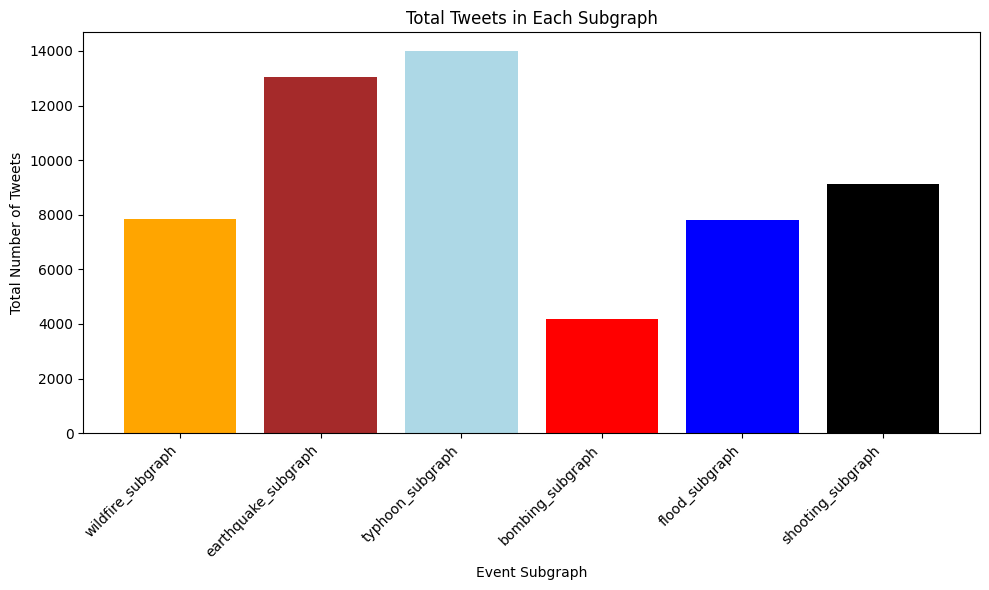

In [17]:
# Extract subgraph names and total tweet counts from the dictionary
subgraph_names = list(total_tweets_dict.keys())
total_tweets_counts = list(total_tweets_dict.values())

# Define colors for each subgraph
colors = ['orange', 'brown', 'lightblue', 'red', 'blue', 'black']

# Plot the bar graph with specified colors
plt.figure(figsize=(10, 6))
plt.bar(subgraph_names, total_tweets_counts, color=colors)

# Add labels and title
plt.xlabel('Event Subgraph')
plt.ylabel('Total Number of Tweets')
plt.title('Total Tweets in Each Subgraph')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
total_tweets_dict = {}

for subgraph_name, subgraph in subgraphs.items():
    # Initialize counters for tweets and retweets
    total_tweets = 0
    total_retweets = 0
    
    # Iterate over nodes to count tweets
    for node, data in subgraph.nodes(data=True):
        if data.get('labels') == ':Tweet':
            total_tweets += 1
            
    # Iterate over edges to count retweets
    for source, target, data in subgraph.edges(data=True):
        if data.get('label') == 'RETWEETS':
            total_retweets += data.get('times', 0)
    
    # Update total_tweets_dict with total counts
    total_tweets_dict[subgraph_name] = total_tweets + total_retweets

# Print the total tweets (including retweets) in each subgraph
print("Total tweets (including retweets) in each subgraph:")
for subgraph_name, total_tweets in total_tweets_dict.items():
    print(f"{subgraph_name}: {total_tweets}")

Total tweets (including retweets) in each subgraph:
wildfire_subgraph: 9055
earthquake_subgraph: 13602
typhoon_subgraph: 14685
bombing_subgraph: 5175
flood_subgraph: 9699
shooting_subgraph: 10248


If we include retweets in our tweet count, the ranking established above remains unchanged. 

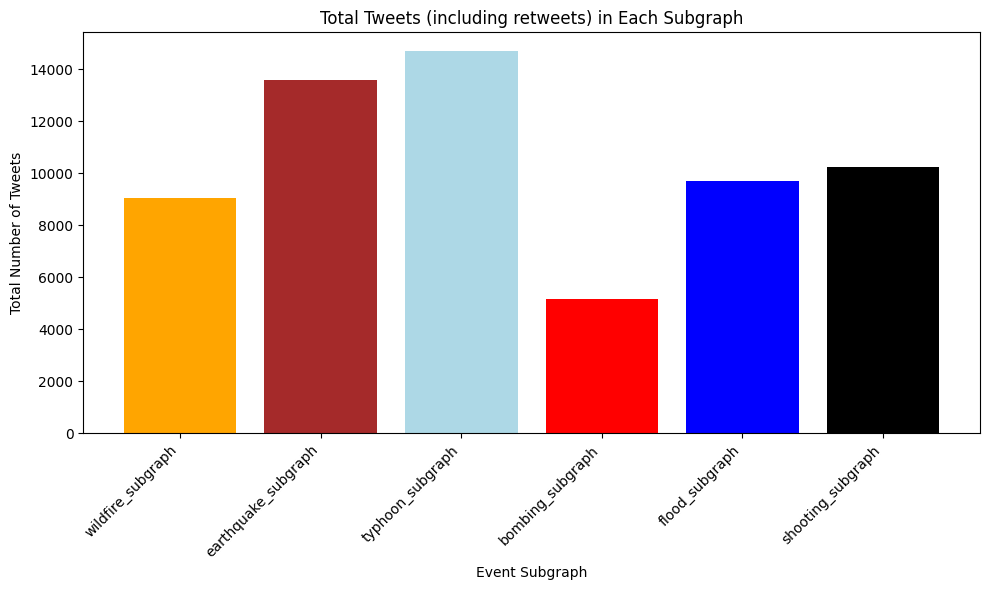

In [19]:
# Extract subgraph names and total tweet counts from the dictionary
subgraph_names = list(total_tweets_dict.keys())
total_tweets_counts = list(total_tweets_dict.values())

# Define colors for each subgraph
colors = ['orange', 'brown', 'lightblue', 'red', 'blue', 'black']

# Plot the bar graph with specified colors
plt.figure(figsize=(10, 6))
plt.bar(subgraph_names, total_tweets_counts, color=colors)

# Add labels and title
plt.xlabel('Event Subgraph')
plt.ylabel('Total Number of Tweets')
plt.title('Total Tweets (including retweets) in Each Subgraph')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

### 1.1.2 Total followers reached by tweets per subgraph

In [20]:
total_followers_dict = {}

for subgraph_name, subgraph in subgraphs.items():
    total_followers = 0
    for tweet_node, user_node, data in subgraph.edges(data=True):
        if subgraph.nodes[user_node]['labels'] == ':User':
            followers_count = subgraph.nodes[user_node].get('followers_count', 0)
            total_followers += followers_count
    total_followers_dict[subgraph_name] = total_followers

print("Total followers reached by tweets in each subgraph:")
for subgraph_name, total_followers in total_followers_dict.items():
    print(f"{subgraph_name}: {total_followers}")
#doesn't consider overlap between followers of some users and followers of others.

Total followers reached by tweets in each subgraph:
wildfire_subgraph: 6584571677
earthquake_subgraph: 43958223903
typhoon_subgraph: 26431793991
bombing_subgraph: 15111112629
flood_subgraph: 10938357426
shooting_subgraph: 38286340467


We notice that tweets in the earthquake subgraph tend to reach the most followers, followed by tweets in the shooting subgraph, the typhoon subgraph, the bombing subgraph, the flood subgraph and finally the wildfire subgraph

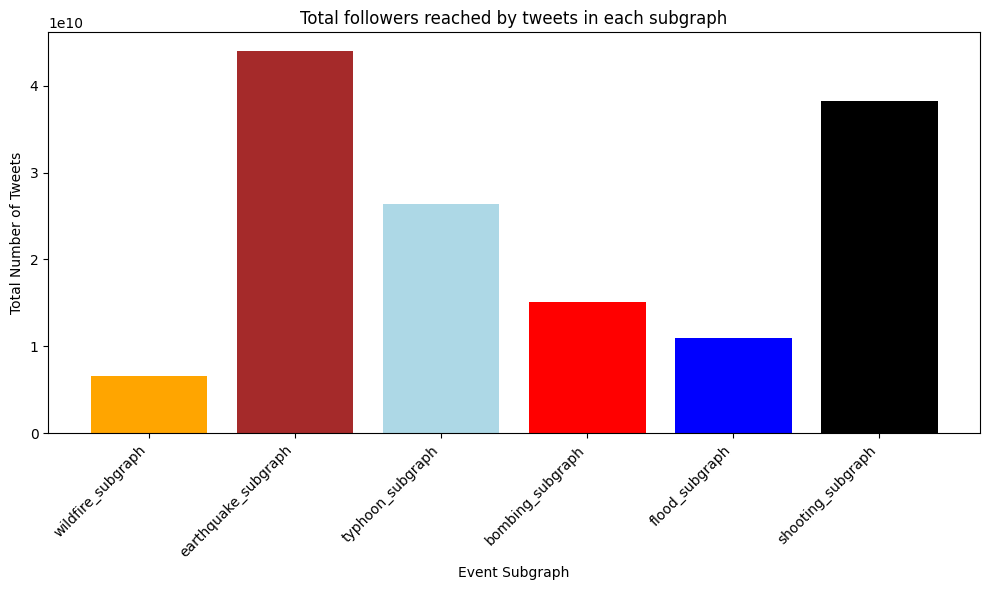

In [21]:
subgraph_names = list(total_tweets_dict.keys())
total_tweets_counts = list(total_followers_dict.values())

# Define colors for each subgraph
colors = ['orange', 'brown', 'lightblue', 'red', 'blue', 'black']

# Plot the bar graph with specified colors
plt.figure(figsize=(10, 6))
plt.bar(subgraph_names, total_tweets_counts, color=colors)

# Add labels and title
plt.xlabel('Event Subgraph')
plt.ylabel('Total Number of Tweets')
plt.title('Total followers reached by tweets in each subgraph')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

### 1.1.3 Hashtags per subgraph

In [22]:
hashtags = []

# Iterate over nodes in the subgraph
for node, data in graph.nodes(data=True):
    # Check if the node has labels ":Hashtag"
    if data.get('labels') == ':Hashtag':
        # Append the hashtag ID to the list
        hashtags.append(data['id'])

print(len(hashtags))
print(len(set(hashtags)))

# exemples
hashtags[:10]

10441
10441


['ymmfire',
 'RubyPH',
 'NepalEarthquake',
 'ymm',
 'Nepal',
 'Hagupit',
 'earthquake',
 'CycloneKenneth',
 'Philippines',
 'Mozambique']

There is 10,441 different subgraphs in total

In [23]:
from collections import Counter

# Initialize an empty dictionary to store DataFrames for each subgraph
hashtag_dfs = {}

# Iterate over each subgraph
for subgraph_name, subgraph in subgraphs.items():
    # Initialize an empty list to store all hashtag words
    hashtag_words = []

    # Iterate over nodes in the subgraph
    for node, data in subgraph.nodes(data=True):
        # Check if the node has labels ":Tweet"
        if data.get('labels') == ':Tweet':
            # Get the text of the tweet
            tweet_text = data.get('text', '')
            # Split the text into words
            words = tweet_text.split()
            # Extract words starting with "#"
            hashtag_words.extend([word.strip("#") for word in words if word.startswith("#")])

    # Convert the list of hashtag words into a Counter object to count occurrences
    hashtag_counts = Counter(hashtag_words)

    # Convert the Counter object into a pandas DataFrame
    hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=['Hashtag', 'Occurences'])

    # Sort the DataFrame by the number of occurrences in descending order
    hashtag_df = hashtag_df.sort_values(by='Occurences', ascending=False)

    # Reset the index of the DataFrame
    hashtag_df = hashtag_df.reset_index(drop=True)

    # Store the DataFrame in the dictionary with the subgraph name as the key
    hashtag_dfs[subgraph_name] = hashtag_df

# Print the DataFrames for each subgraph
for subgraph_name, df in hashtag_dfs.items():
    print(f"Exemples of Hashtags for {subgraph_name} subgraph:")
    print(df[:4])

Exemples of Hashtags for wildfire_subgraph subgraph:
    Hashtag  Occurences
0   ymmfire        2408
1       ymm        1174
2  nswfires         418
3    abfire         381
Exemples of Hashtags for earthquake_subgraph subgraph:
           Hashtag  Occurences
0  NepalEarthquake        1154
1            Nepal         873
2       earthquake         629
3       NepalQuake         334
Exemples of Hashtags for typhoon_subgraph subgraph:
             Hashtag  Occurences
0             RubyPH        1791
1            Hagupit         745
2     CycloneKenneth         537
3  HurricaneFlorence         423
Exemples of Hashtags for bombing_subgraph subgraph:
        Hashtag  Occurences
0  PrayForParis         325
1         Paris         191
2  prayforparis         131
3  ParisAttacks         109
Exemples of Hashtags for flood_subgraph subgraph:
        Hashtag  Occurences
0      yycflood         533
1        bigwet         512
2       abflood         296
3  DurbanFloods         243
Exemples of Hashta

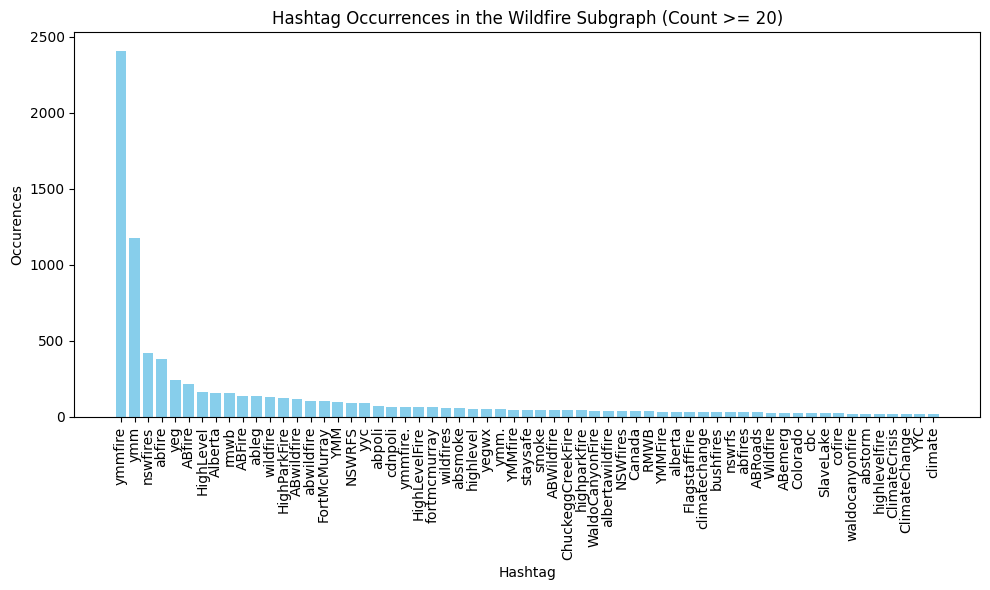

In [24]:
wildfire_hashtags_df = hashtag_dfs['wildfire_subgraph']
wildfire_hashtags_df['Subgraph'] = "Wildfire"

filtered_hashtag_df = wildfire_hashtags_df[wildfire_hashtags_df['Occurences'] >= 20]

# Plot the filtered DataFrame as a histogram
plt.figure(figsize=(10, 6))
plt.bar(filtered_hashtag_df['Hashtag'], filtered_hashtag_df['Occurences'], color='skyblue')
plt.xlabel('Hashtag')
plt.ylabel('Occurences')
plt.title('Hashtag Occurrences in the Wildfire Subgraph (Count >= 20)')
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.show()

The hashtag "ymmfire" was by far the most used hashtag in the wildfire subgraph with 2,408 total occurences

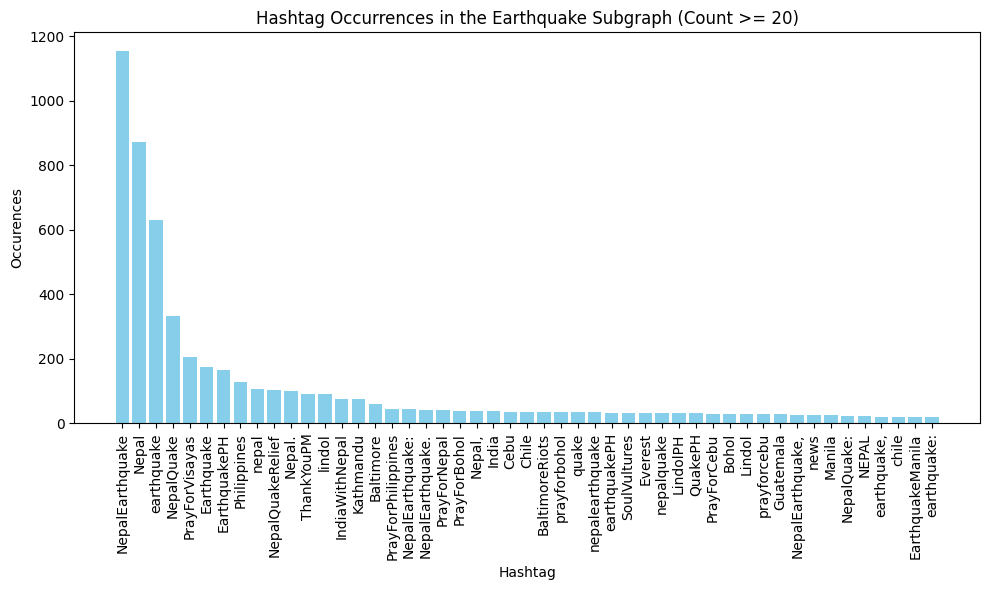

In [25]:
earthquake_hashtags_df = hashtag_dfs['earthquake_subgraph']
earthquake_hashtags_df['Subgraph'] = "Earthquake"

filtered_hashtag_df = earthquake_hashtags_df[earthquake_hashtags_df['Occurences'] >= 20]

# Plot the filtered DataFrame as a histogram
plt.figure(figsize=(10, 6))
plt.bar(filtered_hashtag_df['Hashtag'], filtered_hashtag_df['Occurences'], color='skyblue')
plt.xlabel('Hashtag')
plt.ylabel('Occurences')
plt.title('Hashtag Occurrences in the Earthquake Subgraph (Count >= 20)')
plt.xticks(rotation=90) 
plt.tight_layout()  
plt.show()

The hashtag "NepalEarthquake" was by far the most used hashtag in the earthquake subgraph with 1,154 total occurences

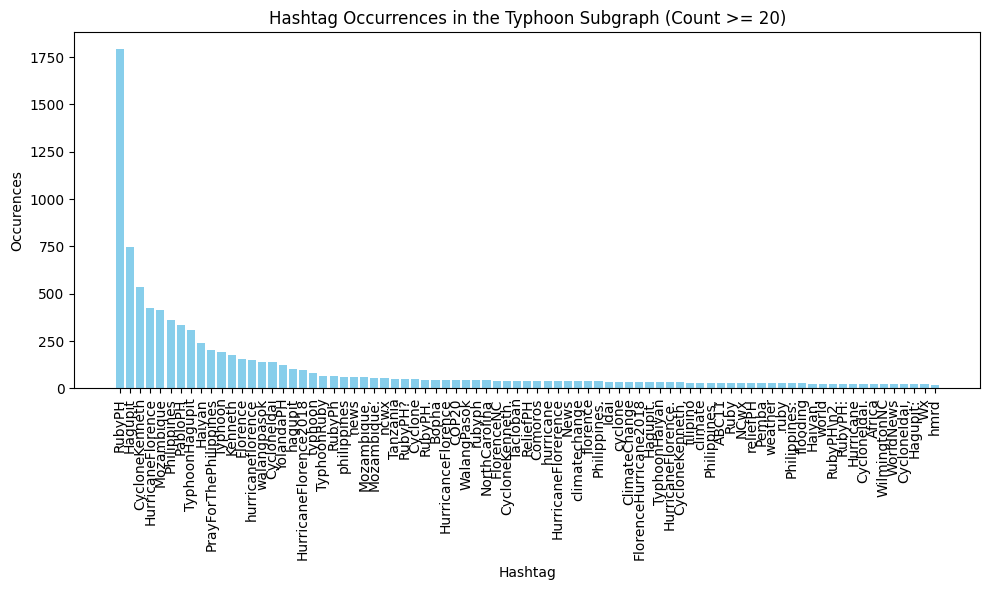

In [26]:
typhoon_hashtags_df = hashtag_dfs['typhoon_subgraph']
typhoon_hashtags_df['Subgraph'] = "Typhoon"

filtered_hashtag_df = typhoon_hashtags_df[typhoon_hashtags_df['Occurences'] >= 20]

# Plot the filtered DataFrame as a histogram
plt.figure(figsize=(10, 6))
plt.bar(filtered_hashtag_df['Hashtag'], filtered_hashtag_df['Occurences'], color='skyblue')
plt.xlabel('Hashtag')
plt.ylabel('Occurences')
plt.title('Hashtag Occurrences in the Typhoon Subgraph (Count >= 20)')
plt.xticks(rotation=90) 
plt.tight_layout()  
plt.show()

The hashtag "RubyPH" was by far the most used hashtag in the typhoon subgraph with 1,791 total occurences

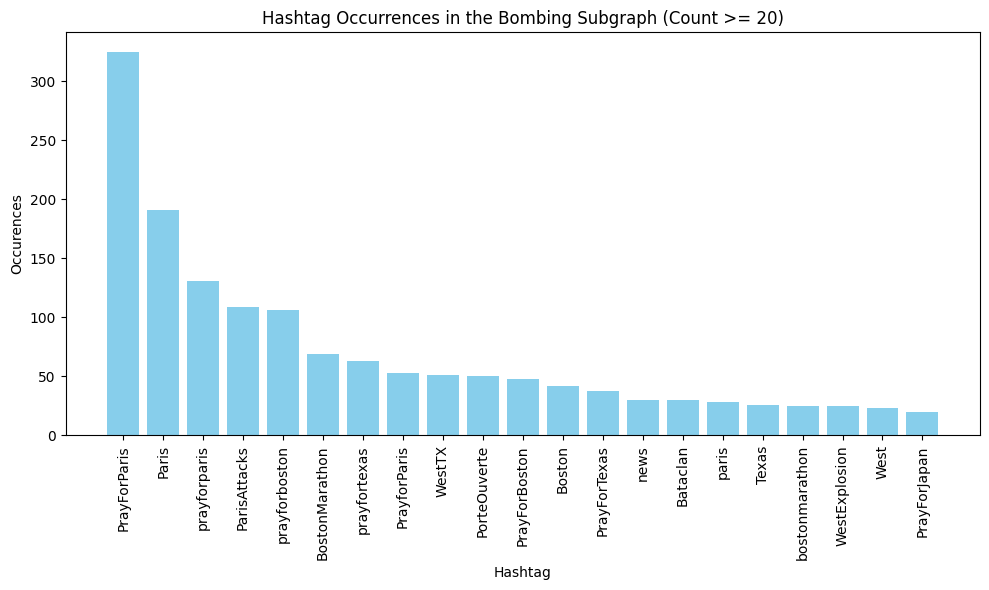

In [27]:
bombing_hashtags_df = hashtag_dfs['bombing_subgraph']
bombing_hashtags_df['Subgraph'] = "Bombing" 

filtered_hashtag_df = bombing_hashtags_df[bombing_hashtags_df['Occurences'] >= 20]

# Plot the filtered DataFrame as a histogram
plt.figure(figsize=(10, 6))
plt.bar(filtered_hashtag_df['Hashtag'], filtered_hashtag_df['Occurences'], color='skyblue')
plt.xlabel('Hashtag')
plt.ylabel('Occurences')
plt.title('Hashtag Occurrences in the Bombing Subgraph (Count >= 20)')
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.show()

The hashtag "PrayForParis" was by far the most used hashtag in the bombing subgraph with 325 total occurences

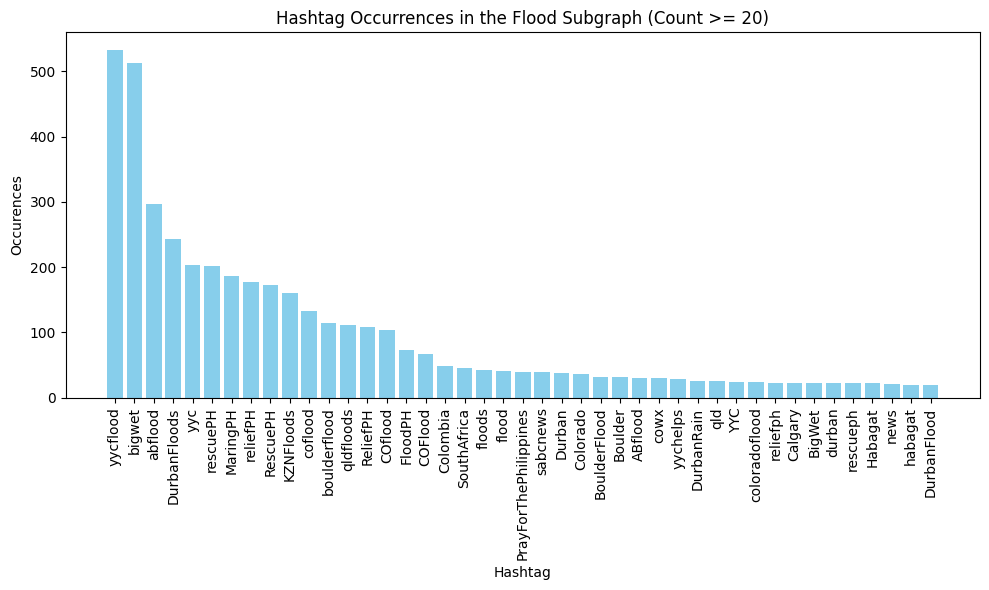

In [28]:
flood_hashtags_df = hashtag_dfs['flood_subgraph']
flood_hashtags_df['Subgraph'] = "Flood"

filtered_hashtag_df = flood_hashtags_df[flood_hashtags_df['Occurences'] >= 20]

# Plot the filtered DataFrame as a histogram
plt.figure(figsize=(10, 6))
plt.bar(filtered_hashtag_df['Hashtag'], filtered_hashtag_df['Occurences'], color='skyblue')
plt.xlabel('Hashtag')
plt.ylabel('Occurences')
plt.title('Hashtag Occurrences in the Flood Subgraph (Count >= 20)')
plt.xticks(rotation=90) 
plt.tight_layout()  
plt.show()

The hashtag "yycflood" was by far the most used hashtag in the flood subgraph with 533 total occurences

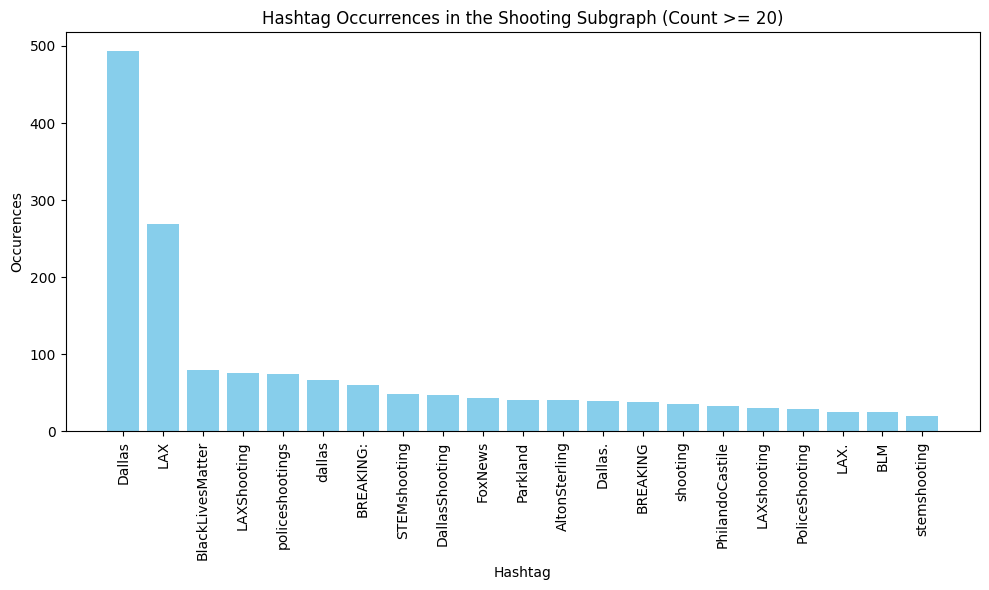

In [29]:
shooting_hashtags_df = hashtag_dfs['shooting_subgraph']
shooting_hashtags_df['Subgraph'] = "Shooting"

filtered_hashtag_df = shooting_hashtags_df[shooting_hashtags_df['Occurences'] >= 20]

# Plot the filtered DataFrame as a histogram
plt.figure(figsize=(10, 6))
plt.bar(filtered_hashtag_df['Hashtag'], filtered_hashtag_df['Occurences'], color='skyblue')
plt.xlabel('Hashtag')
plt.ylabel('Occurences')
plt.title('Hashtag Occurrences in the Shooting Subgraph (Count >= 20)')
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.show()

The hashtag "Dallas" was by far the most used hashtag in the shooting subgraph with 493 total occurences.

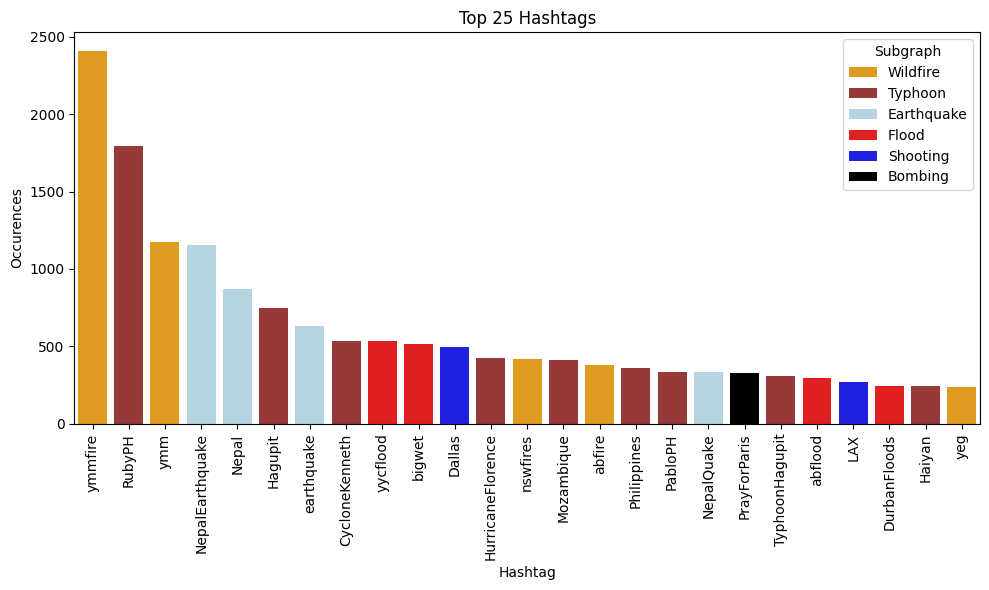

In [30]:
hashtags_dfs = [wildfire_hashtags_df, earthquake_hashtags_df, typhoon_hashtags_df, bombing_hashtags_df, flood_hashtags_df, shooting_hashtags_df] 

# Concatenate the DataFrames along rows
combined_hashtags_dfs = pd.concat(hashtags_dfs, ignore_index=True)

combined_hashtags_dfs_sorted = combined_hashtags_dfs.sort_values(by='Occurences', ascending=False)

# The top 25 rows
top_hashtags = combined_hashtags_dfs_sorted.head(25)

# Histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='Hashtag', y='Occurences', hue='Subgraph', data=top_hashtags, palette=colors)
plt.title('Top 25 Hashtags')
plt.xlabel('Hashtag')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 1.2 The Central Users Based on Different Criteria

In a Twitter network, different centrality measures can provide insights into a user's ability to connect with others, spread information, and gather information. Here are centrality measures relevant to each of these aspects:

**Connecting Users:**

*Betweenness Centrality*: Users with high betweenness centrality act as bridges between different parts of the network, facilitating communication and connections between otherwise disconnected users or communities. They play a crucial role in connecting users and fostering network cohesion.

Note that the calling of the beetweenness centrality function takes time, and that the code chunks can be long to run. Do not hesitate to comment the *nx.betweenness_centrality* function in the following function, that will highly speed up computation.

**Spreading Information:**

*Degree Centrality*: Users with high degree centrality are connected to a large number of other users through interactions such as mentions, retweets, replies, and follows. They have the potential to reach a wide audience and play a significant role in spreading information within the network.

**Gathering Information:**

*Closeness Centrality*: Users with high closeness centrality are close to other users in terms of shortest path distances, allowing them to quickly access information from a wide range of sources within the network. They are well-positioned to gather information efficiently and maintain awareness of network dynamics.


In the following, we will only consider the user nodes of our network and calculate for each of our event-based subgraphs the top 5 users with the highest betweenness centrality, degree centrality and closeness centrality.

In [31]:
# let us first define a function to compute the centralities measures of a given subgraph
def centrality_function(graph):
    # Filter nodes to only include user nodes
    filtered_nodes = [node for node, data in graph.nodes(data=True) if ':User' in data.get('labels', '') or ':Tweet' in data.get('labels', '')]

    # Create a subgraph containing only user nodes
    user_subgraph = graph.subgraph(filtered_nodes)

    # Calculate centralities for user nodes
    centralities = {
        'betweenness_centrality': nx.betweenness_centrality(user_subgraph),
        'degree_centrality': nx.degree_centrality(user_subgraph),
        'closeness_centrality': nx.closeness_centrality(user_subgraph)
    }

    # Identify top 3 users with the highest centralities per centrality measure
    top_users_by_centrality = {}

    for centrality_measure, centrality_dict in centralities.items():
        top_users_by_centrality[centrality_measure] = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:3]

    # Print top 3 users with the highest centralities and all node attributes
    for centrality_measure, top_users in top_users_by_centrality.items():
        print(f"Top 3 users by {centrality_measure}:")
        for user_id, centrality_score in top_users:
            node_data = user_subgraph.nodes[user_id]
            print(f"\tUser {user_id} - Centrality: {centrality_score}")
            for key, value in node_data.items():
                print(f"\t\t{key}: {value}")
        print("")

### 1.2.1 Wildfire subgraph

In [32]:
centrality_function(wildfire_subgraph)

Top 3 users by betweenness_centrality:
	User n85174 - Centrality: 0.0002896506132692833
		labels: :User
		listed_count: 1327
		statuses_count: 121576
		favourites_count: 179
		isVerified: True
		screen_name: ctvedmonton
		friends_count: 1016
		followers_count: 183060
		name: CTV Edmonton
		tweets_count: 67
		id: 20812193
	User n85147 - Centrality: 0.00017626128949578258
		labels: :User
		statuses_count: 26260
		favourites_count: 1647
		isVerified: True
		screen_name: RMWoodBuffalo
		followers_count: 27172
		listed_count: 204
		name: Regional Municipality of Wood Buffalo
		tweets_count: 51
		id: 229905252
		friends_count: 267
	User n85177 - Centrality: 0.000143653722912833
		labels: :User
		isVerified: True
		followers_count: 5836
		listed_count: 170
		statuses_count: 13905
		favourites_count: 170
		id: 24550000
		screen_name: BreannaCTV
		friends_count: 1072
		name: Breanna Karstens-Smith
		tweets_count: 53

Top 3 users by degree_centrality:
	User n61678 - Centrality: 0.019296607531901

In the wildfire subgraph:

- User node n87002, who goes by the screen name "yulsman" and has 1,897 followers has the highest betweeness centrality. They are the best at connecting users.

- User node n88567, who goes by the screen name "BreakingNews" and has 9,345,296 followers has the highest degree centrality. They are the best at spreading information. 

- User node n64463, who goes by the screen name "AP" (The Associated Press) and has 12,790,776 followers has the highest closeness centrality. They are the best at gathering information. 

For each centrality, the top 3 is listed above, with all their respective attributes, if one wants to gain more insight on other central users within our twitter network for each centrality.

### 1.2.2 Earthquake Subgraph

In [33]:
centrality_function(earthquake_subgraph)

Top 3 users by betweenness_centrality:
	User n88567 - Centrality: 9.633881586165645e-06
		labels: :User
		listed_count: 88434
		statuses_count: 102605
		favourites_count: 6
		isVerified: True
		screen_name: BreakingNews
		friends_count: 546
		followers_count: 9345296
		name: Breaking News
		tweets_count: 30
		id: 6017542
	User n90039 - Centrality: 7.842415441657725e-06
		labels: :User
		isVerified: False
		followers_count: 891454
		listed_count: 10686
		statuses_count: 29037
		favourites_count: 0
		id: 83972205
		screen_name: NewEarthquake
		friends_count: 8
		name: Earthquakes Tsunamis
		tweets_count: 30
	User n89546 - Centrality: 7.520610349221366e-06
		labels: :User
		listed_count: 690
		statuses_count: 21699
		favourites_count: 24
		isVerified: True
		screen_name: phivolcs_dost
		friends_count: 21
		followers_count: 367810
		name: PHIVOLCS-DOST
		tweets_count: 42
		id: 802064401

Top 3 users by degree_centrality:
	User n90039 - Centrality: 0.008795363939007851
		labels: :User
		isV

In the earthquake subgraph:

- User node n88567, who goes by the screen name "BreakingNews" and has 9,345,296 followers has the highest betweeness centrality. They are the best at connecting users.

- User node n90039, who goes by the screen name "NewEarthquake" and has 891,454 followers has the highest degree centrality. They are the best at spreading information. 

- User node n96126, who goes by the screen name "narendramodi" (the prime minister of India) and has 43,346,394 followers has the highest closeness centrality. They are the best at gathering information. 

For each centrality, the top 3 is listed above, with all their respective attributes, if one wants to gain more insight on other central users within our twitter network for each centrality.

### 1.2.3 Shooting Subgraph

In [34]:
centrality_function(shooting_subgraph)

Top 3 users by betweenness_centrality:
	User n83848 - Centrality: 5.826608844066396e-06
		labels: :User
		favourites_count: 1437
		isVerified: True
		friends_count: 1110
		followers_count: 41613138
		listed_count: 138033
		statuses_count: 233911
		name: CNN
		tweets_count: 27
		id: 759251
		screen_name: CNN
	User n64465 - Centrality: 5.543602128783171e-06
		labels: :User
		listed_count: 38910
		statuses_count: 160798
		favourites_count: 770
		isVerified: True
		screen_name: NBCNews
		friends_count: 2799
		followers_count: 6095523
		name: NBC News
		tweets_count: 23
		id: 14173315
	User n88246 - Centrality: 4.907669392087924e-06
		labels: :User
		isVerified: True
		followers_count: 55261111
		listed_count: 182963
		statuses_count: 66181
		favourites_count: 20
		id: 428333
		screen_name: cnnbrk
		friends_count: 121
		name: CNN Breaking News
		tweets_count: 62

Top 3 users by degree_centrality:
	User n96724 - Centrality: 0.0185794241532514
		labels: :User
		favourites_count: 24
		isVerifi

In the shooting subgraph:

- User node n83848, who goes by the screen name "CNN" and has 41,613,138 followers has the highest betweeness centrality. They are the best at connecting users.

- User node n96724, who goes by the screen name "realDonaldTrump" (the previous Uninted States president) and has 48,268,973 followers has the highest degree centrality. They are the best at spreading information. 

- User node n96724 (again), who goes by the screen name "realDonaldTrump" and has 48,268,973 followers has the highest closeness centrality. They are the best at gathering information. 

For each centrality, the top 3 is listed above, with all their respective attributes, if one wants to gain more insight on other central users within our twitter network for each centrality.

### 1.2.4 Bombing Subgraph

In [35]:
centrality_function(bombing_subgraph)

Top 3 users by betweenness_centrality:
	User n88246 - Centrality: 1.676101592207595e-05
		labels: :User
		isVerified: True
		followers_count: 55261111
		listed_count: 182963
		statuses_count: 66181
		favourites_count: 20
		id: 428333
		screen_name: cnnbrk
		friends_count: 121
		name: CNN Breaking News
		tweets_count: 62
	User n88567 - Centrality: 1.5760690038132423e-05
		labels: :User
		listed_count: 88434
		statuses_count: 102605
		favourites_count: 6
		isVerified: True
		screen_name: BreakingNews
		friends_count: 546
		followers_count: 9345296
		name: Breaking News
		tweets_count: 30
		id: 6017542
	User n64463 - Centrality: 9.403063309069133e-06
		labels: :User
		listed_count: 92296
		statuses_count: 220355
		favourites_count: 1616
		isVerified: True
		id: 51241574
		screen_name: AP
		friends_count: 7175
		followers_count: 12790776
		name: The Associated Press
		tweets_count: 46

Top 3 users by degree_centrality:
	User n64463 - Centrality: 0.011320754716981131
		labels: :User
		liste

In the bombing subgraph:

- User node n88246, who goes by the screen name "cnnbrk" (CNN Breaking News) and has 55,261,111 followers has the highest betweeness centrality. They are the best at connecting users.

- User node n64463, who goes by the screen name "AP" (The Associated Press) and has 12,790,776 followers has the highest degree centrality. They are the best at spreading information. 

- User node n64463 (again), who goes by the screen name "AP" (The Associated Press) and has 12,790,776 followers has the highest closeness centrality. They are the best at gathering information. 

For each centrality, the top 3 is listed above, with all their respective attributes, if one wants to gain more insight on other central users within our twitter network for each centrality.

### 1.2.5 Flood Subgraph

In [36]:
centrality_function(flood_subgraph)

Top 3 users by betweenness_centrality:
	User n98043 - Centrality: 3.08602392634701e-05
		labels: :User
		listed_count: 2575
		statuses_count: 55856
		favourites_count: 85
		isVerified: True
		screen_name: nenshi
		friends_count: 1248
		followers_count: 376529
		name: Naheed Nenshi
		tweets_count: 6
		id: 33798654
	User n63257 - Centrality: 2.38208364172203e-05
		labels: :User
		isVerified: True
		followers_count: 181626
		listed_count: 1407
		statuses_count: 55981
		favourites_count: 1739
		id: 59338142
		screen_name: QldPolice
		friends_count: 358
		name: Queensland Police
		tweets_count: 33
	User n61531 - Centrality: 2.1271566957899838e-05
		labels: :User
		isVerified: True
		followers_count: 230999
		listed_count: 1560
		statuses_count: 24607
		favourites_count: 2019
		id: 15933148
		screen_name: cityofcalgary
		friends_count: 59
		name: City of Calgary
		tweets_count: 20

Top 3 users by degree_centrality:
	User n58501 - Centrality: 0.007161596823370913
		labels: :User
		isVerified:

In the flood subgraph:

- User node n98043, who goes by the screen name "nenshi" and has 376,529 followers has the highest betweeness centrality. They are the best at connecting users.

- User node n58501, who goes by the screen name "ANCALERTS" (ABS-CBN News Channel) and has 4,426,900 followers has the highest degree centrality. They are the best at spreading information. 

- User node n94255, who goes by the screen name "CyrilRamaphosa" (Cyril Ramaphosa, the president of South Africa) and has 569,816 followers has the highest closeness centrality. They are the best at gathering information. 

For each centrality, the top 3 is listed above, with all their respective attributes, if one wants to gain more insight on other central users within our twitter network for each centrality.

### 1.2.6 Typhoon Subgraph

In [37]:
centrality_function(typhoon_subgraph)

Top 3 users by betweenness_centrality:
	User n58501 - Centrality: 3.935551356377194e-05
		labels: :User
		isVerified: True
		followers_count: 4426900
		listed_count: 7480
		statuses_count: 479015
		favourites_count: 5728
		id: 44728980
		screen_name: ANCALERTS
		friends_count: 776
		name: ABS-CBN News Channel
		tweets_count: 95
	User n58317 - Centrality: 3.586567929955789e-05
		labels: :User
		listed_count: 4853
		statuses_count: 93133
		favourites_count: 10
		isVerified: True
		screen_name: dost_pagasa
		friends_count: 14
		followers_count: 5619485
		name: PAGASA-DOST
		tweets_count: 39
		id: 202890266
	User n58484 - Centrality: 2.804897065031776e-05
		labels: :User
		listed_count: 7154
		statuses_count: 534598
		favourites_count: 886
		isVerified: True
		screen_name: ABSCBNNews
		friends_count: 1303
		followers_count: 5554964
		name: ABS-CBN News
		tweets_count: 47
		id: 15872418

Top 3 users by degree_centrality:
	User n58501 - Centrality: 0.011328361217496473
		labels: :User
		isVe

In the typhoon subgraph:

- User node n58501, who goes by the screen name "ANCALERTS" (ABS-CBN News Channel) and has 4,426,900 followers has the highest betweeness centrality. They are the best at connecting users.

- User node n58501 (again), who goes by the screen name "ANCALERTS" (ABS-CBN News Channel) and has 4,426,900 followers has the highest degree centrality. They are the best at spreading information. 

- User node n58317, who goes by the screen name "dost_pagasa" and has 5,619,485 followers has the highest closeness centrality. They are the best at gathering information. 

For each centrality, the top 3 is listed above, with all their respective attributes, if one wants to gain more insight on other central users within our twitter network for each centrality.

We notice, for all subgraphs, that news outlets and the press such as CNN, ABC news, The Asscociated Press, often have the highest betweeness and/or degree centrality. They are the best at connecting users and spreading information. Given their nature, this make a lot of sence. Furthermore, we notice that influencers and polititians often have the highest closeness centrality and are the best at gathering information. 

## 1.3 The Distributions of the Tweet Posts and their Main Topics w.r.t Levels of Criticality Among the “Low”, “Medium”, “High” and “Critical”

We will here analyze the different kinds of events in the twitter network related to different crises. 

There are 6 different types of events :

- *Bombings*
- *Earthquakes*
- *Floods*
- *Shootings*
- *Typhoons*
- *Wildfires*

(Note: To view our analysis for each subgraph, one must change the variable 'chosen_event' below, and run the subsequent code)

In [38]:
chosen_event = 'bombing' #can modify this variable to 'wildfire', 'earthquake', 'flood', 'shooting', 'typhoon' or 'bombing'
g = subgraphs.get(chosen_event + '_subgraph')

First, let us extract all the tweets from the 'chosen_event' events

In [39]:
tweets = []
for node, data in g.nodes(data=True):
    for key, value in data.items():
        if key == 'labels':
            if value == ':Tweet':
                tweets.append({node : data})

print(f"There are {len(tweets)} tweets for the {chosen_event} event type\n")
print("Example of tweet :")
print(tweets[0])

# we remove unknown criticality tweets
tweets = [tweet for tweet in tweets if tweet[list(tweet.keys())[0]]['annotation_postPriority'] != 'Unknown']

There are 4186 tweets for the bombing event type

Example of tweet :
{'n7033': {'labels': ':Tweet', 'is_quote_status': False, 'possibly_sensitive': False, 'retweet_count': 1122, 'favorite_count': 0, 'id_str': '325431240696152064', 'isTruncated': False, 'annotation_postPriority': 'Low', 'created_at': '2013-04-20T00:00Z', 'id': '325431240696152064', 'annotation_annotated': True, 'annotation_num_judgements': 1, 'text': 'RT @PetesWire: BREAKING: Better shot of boat where suspected #bostonmarathon bomber was hiding out. #wbz http://t.co/HsVqIDbMMd', 'topic': 'TRECIS-CTIT-H-012'}}


Then, we extract the events names and add them to the tweets dictionnary for better visualisation 

In [40]:
events = []
for node, data in g.nodes(data=True):
    for key, value in data.items():
        if key == 'labels':
            if value == ':Event':
                events.append({node : data})

events = [list(dict(events[i].items()).values())[0] for i in range(len(events))]
events

[{'labels': ':Event',
  'id': 'bostonBombings2013',
  'trecisid': 'TRECIS-CTIT-H-012',
  'eventType': 'bombing'},
 {'labels': ':Event',
  'id': 'parisAttacks2015',
  'trecisid': 'TRECIS-CTIT-H-021',
  'eventType': 'bombing'},
 {'labels': ':Event',
  'id': 'westTexasExplosion2013',
  'trecisid': 'TRECIS-CTIT-H-006',
  'eventType': 'bombing'}]

In [41]:
for i in range(len(tweets)) : 
    event_id = list(dict(tweets[i].items()).values())[0]['topic']
    for item in events:
        if item.get('trecisid') == event_id:
            desired_event = item

    for inner_dict in tweets[i].values():
        inner_dict['ref_event'] = desired_event['id']

# we have the reference event at the end
tweets[0]

{'n7033': {'labels': ':Tweet',
  'is_quote_status': False,
  'possibly_sensitive': False,
  'retweet_count': 1122,
  'favorite_count': 0,
  'id_str': '325431240696152064',
  'isTruncated': False,
  'annotation_postPriority': 'Low',
  'created_at': '2013-04-20T00:00Z',
  'id': '325431240696152064',
  'annotation_annotated': True,
  'annotation_num_judgements': 1,
  'text': 'RT @PetesWire: BREAKING: Better shot of boat where suspected #bostonmarathon bomber was hiding out. #wbz http://t.co/HsVqIDbMMd',
  'topic': 'TRECIS-CTIT-H-012',
  'ref_event': 'bostonBombings2013'}}

We can see that for each of the tweets, we have added an attribute "ref_event" to their attribute dictionnary. This represents the name of the referenced event in the tweet.

## 1.3.1 Criticality of the tweets count

In [42]:
# first, we convert the list of dictionnaries into a pandas dataframe which will be easier to manipulate
list_of_tweets = [list(dict(tweets[i].items()).values())[0] for i in range(len(tweets))]
df_tweets = pd.DataFrame(list_of_tweets)
df_tweets.head()

# visual purposes
order_crit = ['Critical', 'High', 'Medium', 'Low']
palette = sns.color_palette("coolwarm")
palette = palette[::-1]

Let us visualize the distribution of the criticality of the tweets:

In [43]:
df_tweets['annotation_postPriority'].value_counts()

annotation_postPriority
Low         2248
Medium       320
High         162
Critical      53
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='annotation_postPriority'>

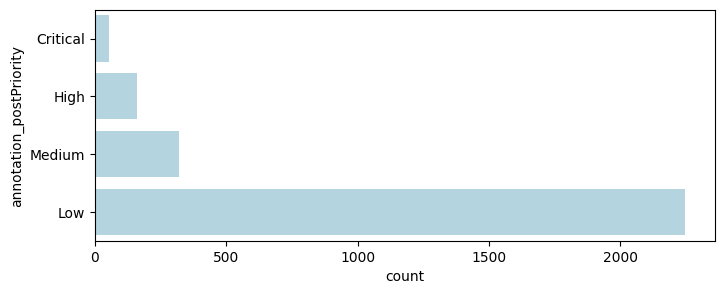

In [44]:
plt.figure(figsize=(8, 3))
sns.countplot(y=df_tweets['annotation_postPriority'], color='lightblue', order=order_crit)

We notice, for all event-types, that:
- low criticality tweets are more common than medium centrality tweets
- medium criticality tweets are more common than high centrality tweets
- high criticality tweets are more common than critical centrality tweets

### 1.3.2 Tweet count for each sub-event, separated by level of criticality
(Note: we define a sub-event as a smaller event of a bigger general event type, for example the colorado fire is a sub-event of event 'wildfire')

/tmp/ipykernel_48532/3534219651.py:1: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.countplot(data=df_tweets,
/tmp/ipykernel_48532/3534219651.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


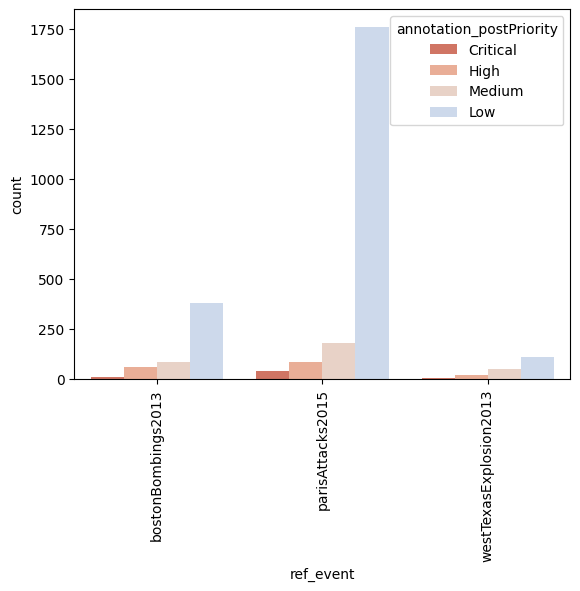

In [45]:
ax = sns.countplot(data=df_tweets, 
                   x='ref_event', 
                   hue='annotation_postPriority', 
                   palette=palette, 
                   hue_order=order_crit)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

- For all event types:

We observe that the majority of tweets are of low priority generally speaking. They usually represent the majority of tweets within sub-events too. However, we still notice some high and critical tweets, which will be interesting to study. An exception arrises when studying the flood and shooting event types, where for the South Africa flood of 2019 and San Diego shooting of 2019, we have high and medium priority tweets respectively that are far more common. 

### 1.3.3 Social activity associated with the tweets by level of criticality

(0.0, 1000.0)

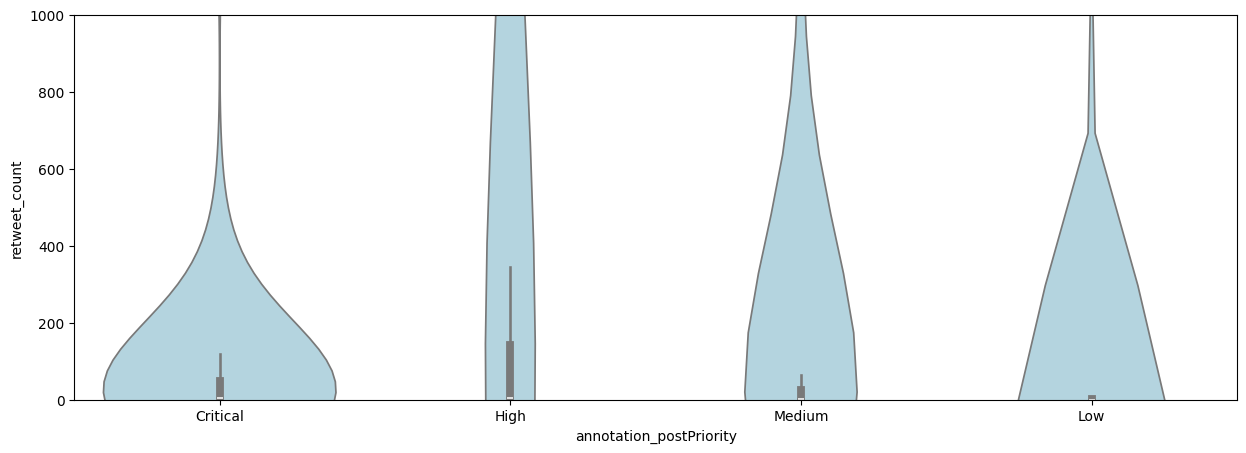

In [46]:
plt.figure(figsize = (15, 5))
sns.violinplot(data = df_tweets,
               x = 'annotation_postPriority',
               y = 'retweet_count',
               order = order_crit,
               color = 'lightblue')
plt.ylim(0, 1000)

- For wildfire event type: 
We observe that while there are numerous outliers with very high retweet counts, likely attributed to tweets from influential or famous users, the overall trend indicates that as tweet criticality increases, tweets tend to receive more retweets on average. This suggests active engagement from the Twitter community in amplifying important information.

- For earthquake event type:
We observe that while there are numerous outliers with high, medium and low retweet counts, likely attributed to tweets from influential or famous users, we observe that critical tweets receive far more retweets on average compared to other criticality types. This is followed by medium and low tweets and finally high criticality tweets who appear to receive far less retweets on average. This suggests active engagement from the Twitter community in amplifying critical information more than anything else.

- For flood and shooting event types:
We observe numerous outliers with high, medium and low retweet counts. Little outliers for critical priority tweets. Contrary to the two previous event types analysed, the critical, high and medium priority tweets appear to have far less average retweets than low priority tweets. This suggests active engagement from the Twitter community in amplifying low priority information more than anything else.

- For typhoon event type: 
We observe many outliers for all the tweet prioprity types. Medium criticality tweets seem to be far more retweeted on average than all the rest. The average retweets seem to be comparable for the other criticality types. This suggests active engagement from the Twitter community in amplifying medium priority information more than anything else.

- For bombing event type: 
We observe little outliers all around. There are far more average retweet counts than the rest of the event types. High criticality tweets seem to be the tweets with the most average retweets by far, followed by medium criticality tweets. This suggests active engagement from the Twitter community in amplifying medium priority information more than anything else.

This can be confirmed by looking at the mean number of retweets by tweet priority :

In [47]:
# we can also look at the mean number of retweets for each level of criticality
df_tweets[['annotation_postPriority', 'retweet_count']].groupby('annotation_postPriority').mean()

,retweet_count
annotation_postPriority,
Critical,132.415094
High,566.308642
Low,107.837189
Medium,251.634375


### 1.3.4 Which events contain the more critical tweets and which are the most retweeted

/tmp/ipykernel_48532/2821723795.py:2: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.boxplot(data=df_tweets[df_tweets['retweet_count'] < 500],
/tmp/ipykernel_48532/2821723795.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


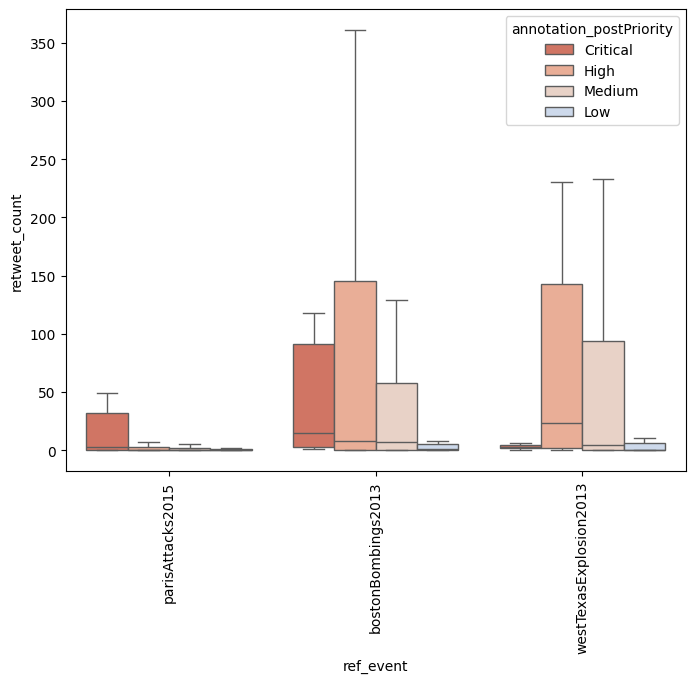

In [48]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df_tweets[df_tweets['retweet_count'] < 500], 
                 x='ref_event', 
                 y='retweet_count', 
                 hue='annotation_postPriority', 
                 showfliers=False,
                 palette=palette,
                 hue_order=order_crit)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

- For wildfire event-type:
The result found in 1.3.3 is confirmed here when we separate the tweets by sub-event. We clearly see the higher values are associated with the higher priority level of tweets in most cases.

- For earthquake, flood, shooting and typhoon event-types:
The result found in 1.3.3 is not necessarily confirmed here when we separate the tweets by sub-event. We notice that the prevelence of retweets by post priority changes from one sub-event to the next.

- For bombing event-types:
We notice that the prevelence of retweets by post priority does not change from one sub-event to the next. 

### 1.3.5 What are the 'favourite counts' for each level of criticality

(0.0, 300.0)

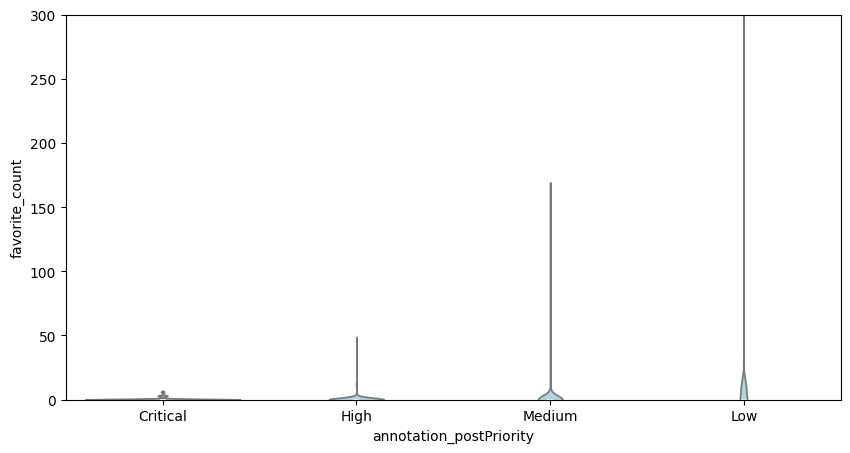

In [49]:
plt.figure(figsize = (10, 5))
sns.violinplot(data = df_tweets,
               x = 'annotation_postPriority',
               y = 'favorite_count',
               order = order_crit,
               color = 'lightblue')
plt.ylim(0, 300)

- For wildfire, earthquake, flood and shooting event types:
The trend seems to be the same than for the retweet counts as the violin plots for each tweet criticality level look almost similar. 

- For typhoon event type:
Favorite counts seem to be more important for critical priority tweets, rather than medium priority tweets which had the highest average retweets.

- For bombing event-types:
Favorite counts seem to be more important for low priority tweets, rather than medium priority tweets which had the highest average retweets.


Let us confirm this intuition by looking at the mean number of favorite for each level of criticality.

In [50]:
df_tweets[['annotation_postPriority', 'favorite_count']].groupby('annotation_postPriority').mean()

,favorite_count
annotation_postPriority,
Critical,0.283019
High,0.512346
Low,2.819840
Medium,1.037500


- For wildfire event type:
The same ranking as before can be observed. Critical tweets has a substancially higher favorite count than high tweets, followed by medium and then low tweets.

- For earthquake event type:
We observe that while there are numerous outliers with high, medium and low favorite counts, we observe that critical tweets receive far more favorites on average compared to other criticality types. This is followed by medium and low tweets and finally high criticality tweets where high tweets appear to receive far less favrites on average. This suggests that critical priority tweets are far more loved by the Twitter community in than anything else.

- For flood event type:
We observe that there are many outliers with high, medium and low favorite counts. There are also very little favorites on average for critical criticality tweets. The type of tweet with the most favorites on average is by far the medium priority tweets.

- For flood event type:
We observe that there are many outliers with medium and low favorite counts. There are also very little favorites on average for critical criticality tweets. The type of tweet with the most favorites on average is by far the low priority tweets.

- For typhoon event type:
Favorite counts are greater for critical priority tweets, than any other types of tweets. Many outliers are present for all priority types.

- For bombing event-types:
Favorite counts seem to be far more important for low priority tweets. Many outliers are observed for these types of tweets too.

### 1.3.6 Sentitivity of the tweets

<Axes: xlabel='annotation_postPriority', ylabel='count'>

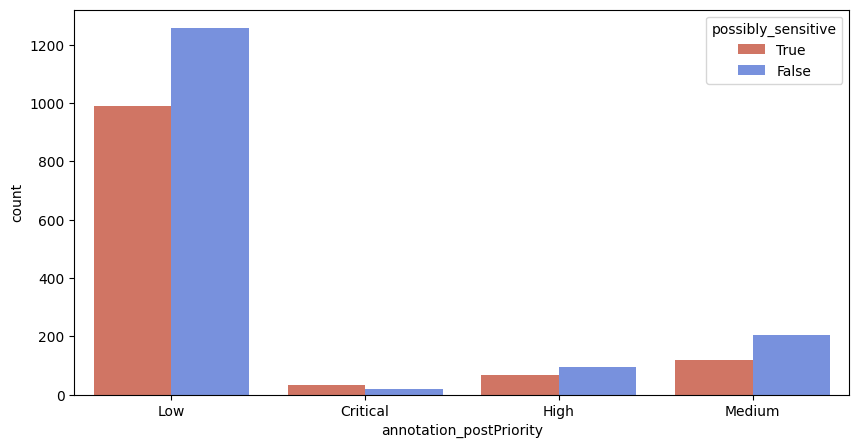

In [51]:
plt.figure(figsize = (10, 5))
sns.countplot(data = df_tweets,
              x = 'annotation_postPriority',
              hue = 'possibly_sensitive',
              hue_order=[True, False],
              palette = [palette[0], palette[-1]])

- For wildfire event type:
We see here that the relative distribution of possibly sensitive tweets is quite comparable between different levels of criticality. It is important to note that usually possiblibly sensitive tweets are fewer in numbers than 'normal' tweets. However, this is not the case for the low criticality tweets.

- For earthquake event type:
We see here that the relative distribution of possibly sensitive tweets is quite comparable between different levels of criticality. It is important to note that usually possiblibly sensitive tweets are fewer in numbers than 'normal' tweets for all priority types. The gap is smaller for low priority tweets.

- For flood and shooting event type:
We see here that the relative distribution of possibly sensitive tweets is quite comparable between different levels of criticality. It is important to note that usually possiblibly sensitive tweets are fewer in numbers, it is not the case for low priority tweets that have a higher frequency of possibly sensitive tweets here.

- For typhoon event type:
Possibly non sensitive tweets are far better represented for all the criticality tweets types.

- For bombing event-types:
Possibly non sensitive tweets are better represented for all the criticality tweets types, except for critical priority tweets where posibly sensitive tweets slightly edge non sensitive ones

### 1.3.7 Comparing the contents of tweets having different levels of criticality 

In [52]:
crit = df_tweets[df_tweets.annotation_postPriority == 'Critical'].reset_index()['text'][0]
high = df_tweets[df_tweets.annotation_postPriority == 'High'].reset_index()['text'][0]
medium = df_tweets[df_tweets.annotation_postPriority == 'Medium'].reset_index()['text'][0]
low = df_tweets[df_tweets.annotation_postPriority == 'Low'].reset_index()['text'][0]
print(crit)
print()
print(high)
print()
print(medium)
print()
print(low)

RT @firstduephotos: BOSTON MA: #wbz news is WRONGLY reporting the JFK Library bomb was recent. It was NOT. BFD has been on scene since i ...

RT @BBCBreaking: Three explosions reported around the Stade de France in the Paris region - French media https://t.co/jTHt0Qh7nJ

RT @biggangVH1: Everyone pray for people in Boston. This was a tragic event that no one deserves, I'm praying for all of you http://t.co ...

RT @PetesWire: BREAKING: Better shot of boat where suspected #bostonmarathon bomber was hiding out. #wbz http://t.co/HsVqIDbMMd


- For wildfire event type:
This example presents interesting distinctions. The critical tweet provides vital information about ongoing events, such as potential solutions to navigate a closed road. The high criticality tweet provides slightly less vital information but it stays relatively informaive. The medium critically tweet is more descriptive than the two previous ones, however there still is some valuable information about the direction of the fire.

Conversely, the low-priority tweet expresses gratitude after the event, directed towards those who participated, which is in stark contrast to the previously described tweets.

This contrast highlights a pattern: high-priority tweets often offer actionable advice to mitigate risks during events, whereas low-priority tweets tend to offer general reflections on the event without specific guidance or recommendations.

- For earthquake event type:
This example presents interesting distinctions. The critical tweet provides good general tips. The high priority tweet provides descriptive updates on the situation. The medium priority tweet provides descriptive information presented in an informal manner. THe low priority tweet provides personal information.

- For flood event type:
The critical and high priority tweets provides descriptive information about infrastructure damage and death toll respectively. THe medium priority tweet shows political developments. Finally, the low priority tweet gives reasurence that rice can survive underwater.

- For shooting event type:
The critical and high priority tweets provides descriptive information about ongoing developments, about the shooter's capture and casualty toll respectively. THe medium priority tweet gives information about both the casulties and the shooters capture. Finally, the low priority tweet gives  a minor descriptive event.

- For typhoon event type:
The critical and high priority tweets provide news updates and information about ongoing developments. The medium criticality tweet gives us a fact about the magnitude of the typhoon. Finally the low criticality tweet is giberish.

- For bombing event type:
The critical and high priority tweets provide breaking news updates and information about ongoing developments. The medium criticality tweet gives us descriptions of the ongoing event. Finally the low criticality tweet is more personal and emotional.

## 2. Embeddings and User-User similarities

### Import the required packages :

In [5]:
import random

%pip install node2vec
from node2vec import Node2Vec

%pip install gensim
import gensim.downloader
from gensim.models import Word2Vec

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr

Note: you may need to restart the kernel to use updated packages.


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.


### Select the event to be analyzed, and import the graph 

In [54]:
chosen_event = 'bombing' #can modify this variable to 'wildfire', 'earthquake', 'flood', 'shooting', 'typhoon' or 'bombing'
g = subgraphs.get(chosen_event + '_subgraph')

### 2.1 - Sampling n users

We want to sample n users based on the centralities of the users in the chosen subgraph. 

- We will then take :
    - The 50 more central users based on their degree centrality 
    - The 50 more central users based on their closeness centrality  

- This means we will get between 50 and 100 users sampled


In [55]:
users = []
nodes_users = []
for node, data in g.nodes(data=True):
    for key, value in data.items():
        if key == 'labels':
            if value == ':User':
                nodes_users.append(node)
                users.append({node : data})

#We choose the size of the sample
n=100

# Sample n/2 users with highest degree centrality
degree_centralities = nx.degree_centrality(g) #We first compute the degree coef fo all nodes
degree_filtred = {key: value for key, value in degree_centralities.items() if key in nodes_users} #We then only select the users nodes
top_degree_users = sorted(degree_filtred, key=lambda x: degree_filtred[x], reverse=True)[0:int(n/2)] #We take the 50 users that have the highest degree centrality


filtered_nodes = [node for node in nodes_users if node not in top_degree_users] #We create a list of all the users except the ones already in the top 50 of degree centrality

# Sample n/2 users with highest closeness centrality (taking away the nodes that are already in the highest degree)
closeness_centralities = nx.closeness_centrality(g) #We first compute the closeness coef fo all nodes
closeness_filtred = {key: value for key, value in closeness_centralities.items() if key in filtered_nodes} #We then only select the users nodes (that are not in the top 50 degree centrality)
top_closeness_users = sorted(closeness_filtred, key=lambda x: closeness_filtred[x], reverse=True)[0:int(n/2)]  #We take the 50 users that have the highest closeness centrality

# List of the selected users
list_user = list(set(top_degree_users + top_closeness_users))

users_sample = []

for node_dict in users:
    node_key = list(node_dict.keys())[0]  
    if node_key in list_user:  
        users_sample.append({node_key: node_dict[node_key]})

# exemple of user 
users_sample[0]

{'n96129': {'labels': ':User',
  'listed_count': 6040,
  'statuses_count': 56505,
  'favourites_count': 7787,
  'isVerified': False,
  'screen_name': 'Conflicts',
  'friends_count': 1404,
  'followers_count': 250388,
  'name': 'Conflict News',
  'tweets_count': 4,
  'id': '2566535282'}}

## 2.ii.a - Embeddings on Graph Structure

Let us create the subgraph containing our sampled users

In [56]:
# first, we need the associated nodes ids to the sample we definded : 
node_sample_ids = []
for i in range(len(users_sample)):
    for key, _ in users_sample[i].items():
        node_sample_ids.append(key)

# define the subgraph with the sample of 100 nodes
sample_graph = g.subgraph(node_sample_ids)

We now need to fit a Node2Vec model on our sub-subgraph, that will create embeddings from the graph structure

In [57]:
# we can then build the embeddings of the sampled graph with Node2Vec
node2vec = Node2Vec(sample_graph, dimensions=50)
fitted_model_n2v = node2vec.fit(window=10, min_count=1) 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 245.31it/s]


We can have access to the 10 most similar nodes of a node, based on cosine similarity

In [58]:
for key, value in users_sample[0].items():
    k = key
fitted_model_n2v.wv.most_similar(k)

[('n88246', 0.9806016087532043),
 ('n64463', 0.9790432453155518),
 ('n95162', 0.9776403307914734),
 ('n97710', 0.975347638130188),
 ('n98523', 0.9745786786079407),
 ('n79100', 0.9741612076759338),
 ('n95694', 0.9733909964561462),
 ('n57899', 0.9723526835441589),
 ('n95135', 0.9710146188735962),
 ('n88567', 0.8153941035270691)]

Or we can build a cosine similarity matrix :

In [59]:
# get the embeddings for every node
node_embeddings_n2v = {node: fitted_model_n2v.wv[node] for node in sample_graph.nodes()}

# list element is easier to handle
list_of_embeddings_n2v = []
for key, value in node_embeddings_n2v.items():
    list_of_embeddings_n2v.append({key : value})

In [60]:
# build the cosine similarity matrix
cos_sim_n2v = [[0 for _ in range(100)] for _ in range(100)]

for i, emb_i_dict in enumerate(list_of_embeddings_n2v):
    for j, emb_j_dict in enumerate(list_of_embeddings_n2v):
        emb_i = next(iter(emb_i_dict.values())) 
        emb_j = next(iter(emb_j_dict.values()))

        cosine_sim = cosine_similarity([emb_i], [emb_j])[0][0]
        cos_sim_n2v[i][j] = cosine_sim

With this cosine similarity matrix, we can easily get a list of highly similar users :

In [61]:
# from this, we can get the more similar users in our sample graph :
arr_cos_sim_n2v = np.array(cos_sim_n2v)
np.fill_diagonal(arr_cos_sim_n2v, -np.inf) # we replace the 1 elements of the diagonal by -inf

# 10 most similar nodes
v = []

nb_users_to_print = 10
for _ in range(nb_users_to_print):
    max_index = np.argmax(arr_cos_sim_n2v)
    max_sim = np.max(arr_cos_sim_n2v)

    max_row_index, max_col_index = np.unravel_index(max_index, np.array(arr_cos_sim_n2v).shape)

    arr_cos_sim_n2v[max_row_index][max_col_index] = -np.inf
    arr_cos_sim_n2v[max_col_index][max_row_index] = -np.inf

    v.append((max_row_index, max_col_index, max_sim))

print(f"The {nb_users_to_print} most similar pairs of users are :")
v

The 10 most similar pairs of users are :


[(91, 96, 0.9893044),
 (2, 26, 0.98060155),
 (2, 44, 0.97904307),
 (9, 26, 0.9779905),
 (2, 30, 0.9776403),
 (2, 38, 0.9753476),
 (26, 92, 0.9752277),
 (2, 92, 0.9745786),
 (35, 56, 0.9744753),
 (2, 93, 0.9741611)]

## 2.ii.b - Embeddings on Post Content

Let us create a list of tweets containing the tweets that were posted by the users in our previously created subgraph

In [62]:
# we already have our sampled graph and the users, we now need the tweets
tweets = []
for node, data in g.nodes(data=True):
    for key, value in data.items():
        if key == 'labels':
            if value == ':Tweet':
                tweets.append({node : data})

# exemple of tweet
tweets[0]

{'n7033': {'labels': ':Tweet',
  'is_quote_status': False,
  'possibly_sensitive': False,
  'retweet_count': 1122,
  'favorite_count': 0,
  'id_str': '325431240696152064',
  'isTruncated': False,
  'annotation_postPriority': 'Low',
  'created_at': '2013-04-20T00:00Z',
  'id': '325431240696152064',
  'annotation_annotated': True,
  'annotation_num_judgements': 1,
  'text': 'RT @PetesWire: BREAKING: Better shot of boat where suspected #bostonmarathon bomber was hiding out. #wbz http://t.co/HsVqIDbMMd',
  'topic': 'TRECIS-CTIT-H-012',
  'ref_event': 'bostonBombings2013'}}

We will need a list of dictionnaries containing the user_id as keys, and their posted tweets as values

In [63]:
# build a list containing dictionnaries with the user_node_id and every tweet made by this user
users_posts = []

for u in users_sample:
    user_node_id = [key for key, _ in u.items()][0]
    tweets_by_user = []
    
    for t in tweets:
        tweet_node_id = [key for key, _ in t.items()][0]
        text_tweet = [value for _, value in t.items()][0]['text']

        if tweet_node_id in g[user_node_id]:
            tweets_by_user.append(text_tweet)

    users_posts.append({'user':user_node_id,
                        'tweets':tweets_by_user})
    
# exemple of users posts :
users_posts[:2]

[{'user': 'n96129',
  'tweets': ['PHOTO: Victims on the pavement at a Paris restaurant. More images from #Paris: https://t.co/erBfTu6cu0 - @USATODAY https://t.co/wtOQHrqWZL',
   '#ParisAttack Update:\\n\\n- Shooting at Restaurant\\n- Multiple explosions at stadium \\n- Hostages taken at Concert Hall\\n- At least 18 dead']},
 {'user': 'n97853',
  'tweets': ['Jeez-I want to love you all,my countrymen in the Texas explosion,Midwest flooding,&amp;Boston.We ARE here for you!Lets help them!']}]

Let us load a pretrained Word2Vec model on tweeter data, that will convert the posts by users into embeddings

In [6]:
# let us build the empbeddings of our tweets, using a pretrained Word2Vec model on twitter data, using embeddings of length 50 to match the graph structure embeddings
w2v = gensim.downloader.load('glove-twitter-50')

We also need a function that will create the embedding of a given tweet

In [65]:
# we define a function that allows us to tokenize a tweet/sentence, and we take the average of each embedding
def sentence_embedding(sentence):
    if len(sentence)>0:
        tokens = sentence.split()
        embeddings = [w2v[token] for token in tokens if token in w2v]
        
        if len(tokens) > 0 and embeddings:
                avg_embedding = np.mean(embeddings, axis=0)
        else:
            avg_embedding = np.zeros(w2v.vector_size)
    else:
         avg_embedding = np.zeros(w2v.vector_size)
    return avg_embedding

Let us compute the embeddings of our set of tweets and add them to the list of dictionnaries

In [66]:
# we then compute and add the embedded tweets to the users_posts list, by adding a key to each dictionnary in the list
for i in users_posts:
    tweets = i['tweets']
    embedded_tweets = []

    if len(tweets) == 0:
        avg_emb_tweet = np.zeros(w2v.vector_size)

    else :
        for j in i['tweets']:
            emb_tweet = sentence_embedding(j)
            embedded_tweets.append(emb_tweet)
            avg_emb_tweet = np.mean(embedded_tweets, axis=0)
    i['embedded_tweets'] = avg_emb_tweet

# exemple of new user post :
users_posts[0]

{'user': 'n96129',
 'tweets': ['PHOTO: Victims on the pavement at a Paris restaurant. More images from #Paris: https://t.co/erBfTu6cu0 - @USATODAY https://t.co/wtOQHrqWZL',
  '#ParisAttack Update:\\n\\n- Shooting at Restaurant\\n- Multiple explosions at stadium \\n- Hostages taken at Concert Hall\\n- At least 18 dead'],
 'embedded_tweets': array([ 3.97868752e-02,  2.67205611e-02,  3.99034739e-01, -4.31537509e-01,
        -2.87209526e-02, -1.23172484e-01,  6.80261850e-01, -2.48252414e-02,
        -1.26931176e-01, -1.72865257e-01,  2.46481553e-01, -1.67364568e-01,
        -4.16143131e+00,  1.90459937e-01,  1.72351927e-01, -4.02568802e-02,
         1.90320820e-01, -3.32386345e-01, -2.19276875e-01, -1.67951569e-01,
        -3.87581885e-02, -4.54297304e-01, -3.09907287e-01, -6.27886891e-01,
         5.76749444e-05, -3.83242965e-04, -3.93041134e-01,  2.31292486e-01,
         1.70104444e-01,  3.01857144e-01,  1.04247376e-01, -1.85705110e-01,
        -4.16977644e-01, -7.83492550e-02,  5.646410

We now can create a cosine similarity matrxi based on our embedded tweets

In [67]:
# we can now compute the cosine similarity matrix like with our graph structure embeddings
cos_sim_w2v = [[0 for _ in range(100)] for _ in range(100)]

for i in range(len(users_posts)):
    for j in range(len(users_posts)):
        if i == j:
            cos_sim_w2v[i][j] = 1
        else:
            emb_i = users_posts[i]['embedded_tweets'].reshape(1, -1)
            emb_j = users_posts[j]['embedded_tweets'].reshape(1, -1)
            cos_sim_w2v[i][j] = cosine_similarity(emb_i, emb_j)[0][0]

Now, we can get a list of very similar users

In [68]:
# finally, we can print the most similar users based on this matrix
arr_cos_sim_w2v = np.array(cos_sim_w2v)
np.fill_diagonal(arr_cos_sim_w2v, -np.inf) # replace the diagonal full of 1s by -inf 

v = []

nb_users_to_print = 10
for _ in range(nb_users_to_print):
    max_index = np.argmax(arr_cos_sim_w2v)
    max_sim = np.max(arr_cos_sim_w2v)

    max_row_index, max_col_index = np.unravel_index(max_index, np.array(arr_cos_sim_w2v).shape)

    arr_cos_sim_w2v[max_row_index][max_col_index] = -np.inf
    arr_cos_sim_w2v[max_col_index][max_row_index] = -np.inf
    
    v.append((max_row_index, max_col_index, max_sim))

print(f"The {nb_users_to_print} more similar pairs of users are :")
v

The 10 more similar pairs of users are :


[(14, 69, 1.0),
 (12, 27, 0.9999999999999999),
 (56, 83, 0.9916604161262512),
 (15, 92, 0.9916112422943115),
 (84, 92, 0.9892027378082275),
 (21, 55, 0.9887111783027649),
 (56, 90, 0.9881798028945923),
 (83, 90, 0.988106906414032),
 (18, 56, 0.9879632592201233),
 (15, 90, 0.9878469705581665)]

In [69]:
# exemple of tweets, we can compare them 
print(users_posts[v[1][0]]['tweets'])
print()
print(users_posts[v[1][1]]['tweets'])

["BREAKING NEWS! TEXAS EXPLOSION: FIVE FIREFIGHTERS AND ONE POLICE OFFICER DEAD IN EXPLOSION AT FERTILIZER PLANT. FOX. 'PRAY FOR TEXAS'.", 'BOSTON: TERRORIST ATTACK! CNN AND CBS ARE OFFICIALLY CALLING THIS A TERRORIST ATTACK! #911BUFF', 'TEXAS EXPLOSION: ANOTHER CHEMICAL TANK ON FIRE AT FERTILIZER PLANT. POLICE URGING EVERYONE IN 30 MILE RADIUS TO EVACUATE NOW! #911BUFF', 'TEXAS EXPLOSION: BREAKING NEWS - 35 PEOPLE INCLUDING 10 FIRST RESPONDERS KILLED BY FERTILIZER BLAST, WEST TX MAYOR SAYS. USATODAY. #911BUFF', 'TEXAS: MASSIVE EXPLOSION U/D - LOCAL HOSPITALS NOTIFIED. EVERY AVAILABLE AMBULANCE DISPATCHED. REPORTS OF CASUALTIES. http://t.co/HGRFdbnkhE', 'BOSTON: POLICE AND FBI URGING ANYONE WITH VIDEO OF THE FINISH LINE AT THE TIME OF THE EXPLOSION SHOULD PLEASE COME FORWARD. RETWEET.', 'BREAKING NEWS - TEXAS EXPLOSION U/D - ENTIRE TOWN OF WEST TEXAS UNDER EVACUATION. TOXIC FUMES SPREADING. EMS COMMAND POST EVACUATING AS WELL']

['New Pictures Purport To Show Tsarnaev Brothers Engaged 

For the earthquake subgraph for example, it seems that both most similar tweets are talking mainly about events that happened in Nepal

## 2.iii - Trends in Correlations

Let us define a general function that summarizes all the steps we just realized, to be looped for all event types

- This function will use the Word2Vec pretrained model that we loaded before, so make sure you have loaded it

In [70]:
def similarity_matrix(selected_graph):

    g = subgraphs.get(selected_graph + '_subgraph')

    users = []
    nodes_users = []
    for node, data in g.nodes(data=True):
        for key, value in data.items():
            if key == 'labels':
                if value == ':User':
                    nodes_users.append(node)
                    users.append({node : data})

    #We choose the size of the sample
    n=100

    # Sample n/2 users with highest degree centrality
    degree_centralities = nx.degree_centrality(g) #We first compute the degree coef fo all nodes
    degree_filtred = {key: value for key, value in degree_centralities.items() if key in nodes_users} #We then only select the users nodes
    top_degree_users = sorted(degree_filtred, key=lambda x: degree_filtred[x], reverse=True)[0:int(n/2)] #We take the 50 users that have the highest degree centrality


    filtered_nodes = [node for node in nodes_users if node not in top_degree_users] #We create a list of all the users except the ones already in the top 50 of degree centrality

    # Sample n/2 users with highest closeness centrality (taking away the nodes that are already in the highest degree)
    closeness_centralities = nx.closeness_centrality(g) #We first compute the closeness coef fo all nodes
    closeness_filtred = {key: value for key, value in closeness_centralities.items() if key in filtered_nodes} #We then only select the users nodes (that are not in the top 50 degree centrality)
    top_closeness_users = sorted(closeness_filtred, key=lambda x: closeness_filtred[x], reverse=True)[0:int(n/2)]  #We take the 50 users that have the highest closeness centrality

    # List of the selected users
    list_user = list(set(top_degree_users + top_closeness_users))

    users_sample = []

    for node_dict in users:
        node_key = list(node_dict.keys())[0]  
        if node_key in list_user:  
            users_sample.append({node_key: node_dict[node_key]})


    # first, we need the associated nodes ids to the sample we definded : 
    node_sample_ids = []
    for i in range(len(users_sample)):
        for key, _ in users_sample[i].items():
            node_sample_ids.append(key)

    # define the subgraph with the sample of 100 nodes
    sample_graph = g.subgraph(node_sample_ids)

    # we can then build the embeddings of the sampled graph with Node2Vec
    node2vec = Node2Vec(sample_graph, dimensions=50)
    fitted_model_n2v = node2vec.fit(window=10, min_count=1) 
    
    # get the embeddings for every node
    node_embeddings_n2v = {node: fitted_model_n2v.wv[node] for node in sample_graph.nodes()}

    # list element is easier to handle
    list_of_embeddings_n2v = []
    for key, value in node_embeddings_n2v.items():
        list_of_embeddings_n2v.append({key : value})

    # build the cosine similarity matrix
    cos_sim_n2v = [[0 for _ in range(100)] for _ in range(100)]

    for i, emb_i_dict in enumerate(list_of_embeddings_n2v):
        for j, emb_j_dict in enumerate(list_of_embeddings_n2v):
            emb_i = next(iter(emb_i_dict.values())) 
            emb_j = next(iter(emb_j_dict.values()))

            cosine_sim = cosine_similarity([emb_i], [emb_j])[0][0]
            cos_sim_n2v[i][j] = cosine_sim


    # we already have our sampled graph and the users, we now need the tweets
    tweets = []
    for node, data in g.nodes(data=True):
        for key, value in data.items():
            if key == 'labels':
                if value == ':Tweet':
                    tweets.append({node : data})


    # build a list containing dictionnaries with the user_node_id and every tweet made by this user
    users_posts = []

    for u in users_sample:
        user_node_id = [key for key, _ in u.items()][0]
        tweets_by_user = []
        
        for t in tweets:
            tweet_node_id = [key for key, _ in t.items()][0]
            text_tweet = [value for _, value in t.items()][0]['text']

            if tweet_node_id in g[user_node_id]:
                tweets_by_user.append(text_tweet)

        users_posts.append({'user':user_node_id,
                            'tweets':tweets_by_user})    


    # we then compute and add the embedded tweets to the users_posts list, by adding a key to each dictionnary in the list
    for i in users_posts:
        tweets = i['tweets']
        embedded_tweets = []

        if len(tweets) == 0:
            avg_emb_tweet = np.zeros(w2v.vector_size)

        else :
            for j in i['tweets']:
                emb_tweet = sentence_embedding(j)
                embedded_tweets.append(emb_tweet)
                avg_emb_tweet = np.mean(embedded_tweets, axis=0)
        i['embedded_tweets'] = avg_emb_tweet

    # we can now compute the cosine similarity matrix like with our graph structure embeddings
    cos_sim_w2v = [[0 for _ in range(100)] for _ in range(100)]

    for i in range(len(users_posts)):
        for j in range(len(users_posts)):
            if i == j:
                cos_sim_w2v[i][j] = 1
            else:
                emb_i = users_posts[i]['embedded_tweets'].reshape(1, -1)
                emb_j = users_posts[j]['embedded_tweets'].reshape(1, -1)
                cos_sim_w2v[i][j] = cosine_similarity(emb_i, emb_j)[0][0]
    return([cos_sim_n2v, cos_sim_w2v])

Loop the function through all the subgraphs

In [71]:
correlation_results = []

events = ['wildfire', 'earthquake', 'typhoon', 'bombing', 'flood', 'shooting']

for event_type in events:

    res = similarity_matrix(event_type)
    
    graph_similarities = [similarity for sublist in res[0] for similarity in sublist]
    content_similarities = [similarity for sublist in res[1] for similarity in sublist]

    # Compute the correlation between the graph structure and tweet content similarities
    correlation, p_value = spearmanr(graph_similarities, content_similarities)
    
    # Append the correlation coefficient and p-value to the results list
    correlation_results.append({'event_type': event_type, 'correlation': correlation, 'p_value': p_value})

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 253.27it/s]


In [72]:
correlation_results

[{'event_type': 'wildfire',
  'correlation': -0.09468375983558731,
  'p_value': 2.3434976647137427e-21},
 {'event_type': 'earthquake',
  'correlation': 0.10579041968309726,
  'p_value': 2.750208403478426e-26},
 {'event_type': 'typhoon',
  'correlation': -0.003586967844736346,
  'p_value': 0.7198546190452856},
 {'event_type': 'bombing',
  'correlation': -0.01868666670369796,
  'p_value': 0.06167901261789722},
 {'event_type': 'flood',
  'correlation': 0.069093795051404,
  'p_value': 4.6201667472119904e-12},
 {'event_type': 'shooting',
  'correlation': 0.030175342210683822,
  'p_value': 0.002545797752764087}]

According to this results, we see that the similarity matrices for the graph structure and post contents are more correlated for the flood and shooting event (higher p-value) than for the earthquake and typhoon events. Moreover we see that in general we observe a positive correlation between the two matrices of similarity except for the shooting event.

## 3. Information Retrieval System

Let us import the nltk package that we will need for stopwords management

In [2]:
%pip install nltk
import nltk
from nltk.corpus import stopwords

Note: you may need to restart the kernel to use updated packages.


Let us re-import the graph to be sure we have the correct file

In [7]:
path = 'database_formated_for_NetworkX.graphml'
graph = nx.read_graphml(path)

We first need the users and tweets of our graph

In [9]:
# retrieve the users of our graph
users = []
nodes_users = []
for node, data in graph.nodes(data=True):
    for key, value in data.items():
        if key == 'labels':
            if value == ':User':
                nodes_users.append(node)
                users.append({node : data})

# exemple of user
print(users[0])

# retrieve the tweets of our graph
tweets = []
for node, data in graph.nodes(data=True):
    for key, value in data.items():
        if key == 'labels':
            if value == ':Tweet':
                tweets.append({node : data['text']})

# exemple of tweet
print(tweets[1])

{'n56568': {'labels': ':User', 'statuses_count': 13211, 'favourites_count': 196, 'isVerified': False, 'screen_name': 'jeffseroka', 'followers_count': 537, 'listed_count': 3, 'name': 'Jeff', 'tweets_count': 1, 'id': '54549327', 'friends_count': 400}}
{'n583': 'RT @northfortynews: Tanker helicopter heads up to Paradise Park to drop water on #HighParkFire. http://t.co/7atRS5cy'}


First, let us build a list containing the Poster of a tweet, his tweet, and the degree centrality of the poster

In [11]:
tweets_and_poster = []
list_centralities = nx.degree_centrality(graph)

for t in tweets:
    for key, value in t.items():
        tweet_id = key
    neighb = list(graph.neighbors(tweet_id))
    for n in neighb:
        if graph.nodes[n]['labels'] == ':User':
            tweets_and_poster.append({'poster' : n,
                                      'tweet' : value,
                                      'deg_centrality' : list_centralities[n]})

# exmple 
tweets_and_poster[0]

{'poster': 'n97153',
 'tweet': 'RT @northfortynews: Tanker helicopter heads up to Paradise Park to drop water on #HighParkFire. http://t.co/7atRS5cy',
 'deg_centrality': 3.6487694525021436e-05}

Remove the stopwords from all of our tweets

In [12]:
# import english stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# function to remove the stopwords from a tweet
def remove_stopwords(tweet):
    words = tweet.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# remove stopwords from all the tweets that we consider
for t in tweets_and_poster:
    t['tweet'] = remove_stopwords(t['tweet'])

# exemple of tweets without stopwords
tweets_and_poster[0]

{'poster': 'n97153',
 'tweet': 'RT @northfortynews: Tanker helicopter heads Paradise Park drop water #HighParkFire. http://t.co/7atRS5cy',
 'deg_centrality': 3.6487694525021436e-05}

Now, let us build a function to get the embeddings of each tweet

We will use the Word2Vec model that we previously loaded for question 2.ii.b

In [14]:
def embeddings(tweet_and_poster):
    tweet = tweet_and_poster['tweet']
    if len(tweet)>0:
        tokens = tweet.split()
        embeddings = [w2v[token] for token in tokens if token in w2v]
        
        if len(tokens) > 0 and embeddings:
                avg_embedding = np.mean(embeddings, axis=0)
        else:
            avg_embedding = np.zeros(w2v.vector_size)
    else:
         avg_embedding = np.zeros(w2v.vector_size)

    return avg_embedding

We compute the weighted embeddings of our tweets and add them to our *tweets_and_poster* list

In [15]:
# add the weighted embedding key to the tweet and poster list of dictionnaries
for t in tweets_and_poster:
    t['weighted_embedding'] = embeddings(t)

# exemple of embedding
tweets_and_poster[0]

{'poster': 'n97153',
 'tweet': 'RT @northfortynews: Tanker helicopter heads Paradise Park drop water #HighParkFire. http://t.co/7atRS5cy',
 'deg_centrality': 3.6487694525021436e-05,
 'weighted_embedding': array([-4.20760036e-01,  2.00962514e-01,  2.38147497e-01, -3.25217485e-01,
        -9.95424986e-02,  2.10649997e-01,  3.53680015e-01, -3.58415008e-01,
         4.78022754e-01, -2.75895000e-01,  2.69982487e-01,  3.42622519e-01,
        -3.56564999e+00, -1.53783247e-01,  3.75955492e-01, -2.09551305e-03,
        -1.24993235e-01, -2.25707754e-01, -1.79225057e-02, -5.40952504e-01,
        -6.60202503e-01, -1.65552258e-01,  3.58484983e-01, -5.21449447e-02,
         2.73209006e-01,  5.84527493e-01, -6.20545030e-01,  3.15060258e-01,
        -3.65589023e-01,  2.90598243e-01, -1.37822896e-01,  4.11496013e-01,
         3.91037539e-02,  3.05325016e-02,  6.40157461e-01, -7.38089830e-02,
        -9.71035063e-02,  3.67083758e-01,  4.46657479e-01,  1.88785002e-01,
        -1.43844992e-01, -3.33050080

Now, let us build the top-k tweets retrieval of a query

- Since the query is supposed to be built of keywords, it should not contain stopwords

- If we compute the cosine similarity of the embedded query and all the embeddings, we can retrieve the top-k more relevant tweets

- We can also account for posters centrality by multiplying the obtained cosine similarities by the degree centrality of the related poster

In [16]:
def top_k_retrieval(keywords, k):
    print(keywords)
    print() 

    embedding = [w2v[token] for token in keywords if token in w2v]
    embedding = np.mean(embedding, axis=0).reshape(1, -1)

    similarity_list = [cosine_similarity(embedding, i['weighted_embedding'].reshape(1, -1)) for i in tweets_and_poster]
    weighted_similarity_list = [similarity_list[i] * tweets_and_poster[i]['deg_centrality']for i in range(len(similarity_list))]

    related_tweets = [i['tweet'] for i in tweets_and_poster]

    sorted_weighted_similarity_list = sorted(zip(weighted_similarity_list, related_tweets), reverse = True)
    sorted_sims, sorted_tweets = zip(*sorted_weighted_similarity_list)

    for i in range(len(sorted_sims[:k])):
        print(f'Cosine Sim : {sorted_sims[i][0][0]} \n Tweet : {sorted_tweets[i]} \n')

In [17]:
query = ['drive', 'fire', 'hospital', 'injury']
k = 10

top_k_retrieval(query, k)

['drive', 'fire', 'hospital', 'injury']



Cosine Sim : 0.003126800060272217 
 Tweet : awful ? ?@cnnbrk: Union official: #LAX shooting first time TSA officer killed duty. http://t.co/l4OgfA3gwZ? 

Cosine Sim : 0.003126800060272217 
 Tweet : RT @tayastarling: awful ? ?@cnnbrk: Union official: #LAX shooting first time TSA officer killed duty. http://t.co/? 

Cosine Sim : 0.003100059926509857 
 Tweet : RT @cnnbrk: Sources: Feds eye taking death penalty table Boston bomb suspect exchange attack details. http://t.co/QHnKInRQxT 

Cosine Sim : 0.003072380553930998 
 Tweet : daughter stuck building shooting Dallas. media blood officers hands! @FoxNews @cnnbrk 

Cosine Sim : 0.0030561715830117464 
 Tweet : TSA agent killed Los Angeles airport shooting - @AP, @NBCNews, @cnnbrk 

Cosine Sim : 0.0030561715830117464 
 Tweet : RT @BreakingNews: TSA agent killed Los Angeles airport shooting - @AP, @NBCNews, @cnnbrk 

Cosine Sim : 0.0030458946712315083 
 Tweet : .@cnnbrk Please lord again. I'm heading scene shooting Poway Synagogue near San Di